## Task 1 


In [1]:
# imports 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np

from torch.utils.data import DataLoader
from sklearn.datasets import make_moons


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'

print(device)

cuda


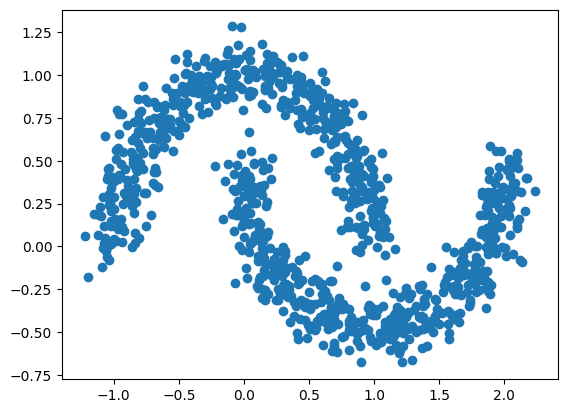

In [3]:
n_samples = 1000

data, _ = make_moons(n_samples=n_samples, noise=0.1)
data = torch.tensor(data, dtype=torch.float32, device=device)

# plot the data 
plt.scatter(data[:, 0].cpu().detach().numpy(), data[:, 1].cpu().detach().numpy())
plt.show()

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.s_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )
        self.t_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x, reversed=False):
        x1, x2 = x.chunk(2, dim=1)

        s = self.s_net(x1)
        t = self.t_net(x1)

        if reversed: # inverted pass
            x2 = (x2 - t) * torch.exp(-torch.tanh(s))
            det = - torch.sum(torch.tanh(s), dim=1)

        else: #normal pass 
            x2 = x2 * torch.exp(torch.tanh(s)) + t
            det = torch.sum(torch.tanh(s), dim=1)

        return torch.cat([x1, x2], dim=1), det


In [5]:
def rand_orthonormal(input_dim, device):
    q, _ = torch.linalg.qr(torch.randn(input_dim, input_dim, device=device))
    return q

class RealNVP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, blocks: int, device: str):
        super(RealNVP, self).__init__()
        self.device = device
        self.blocks = blocks
        self.input_size = input_size
        self.coupling_blocks = nn.ModuleList()
        self.rotation_matrices = []
        
        for _ in range (blocks):
            self.coupling_blocks.append(CouplingLayer(input_size, hidden_size))
            self.rotation_matrices.append(rand_orthonormal(input_size, device=device))

    def forward(self, x, reversed=False):
        tot_det = 0
        if reversed: 
            for i in range(self.blocks-1, -1, -1): # include 0
                # skip the first rotation matrix
                if i < self.blocks - 1:
                    x = x @ self.rotation_matrices[i].T
                x, det = self.coupling_blocks[i](x, reversed=True)
                tot_det += det 

        else: 
            for i in range(self.blocks):
                x, det = self.coupling_blocks[i](x)
                tot_det += det
                # skip the last rotation matrix
                if i < self.blocks - 1:
                    x = x @ self.rotation_matrices[i]

        return x, tot_det
    
    def sample(self, num_samples, device):
        samples = torch.randn(num_samples, self.input_size, device=device)
        return self.forward(samples, reversed=True)
    
    def decoder(self, z, k):
        z[:, k:] = 0
        reconstructed, _ = self.forward(z, reversed=True)
        return reconstructed



In [6]:
def train_inn(model, data, epochs=100, lr=0.001, batch_size=64): 
    model = model.to(device)
    
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(model.input_size).to(device),
        torch.eye(model.input_size).to(device)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        for x in data_loader:
            
            x = x.to(device)

            x_hat, det = model.forward(x)
            log_p = dist.log_prob(x_hat)
            loss = -(log_p + det).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        #print(f'Epoch : {epoch} done')
    return losses

In [7]:
def plot_hyperparameter_results(results, hyperparameter_values, hyperparameter_name):

    fig, axes = plt.subplots(2, len(hyperparameter_values), figsize=(5 * len(hyperparameter_values), 10))

    # Loss curve
    for i, (loss_curve, param_value) in enumerate(zip(results['losses'], hyperparameter_values)):
        axes[0, i].plot(loss_curve, label=f"{hyperparameter_name}: {param_value}")
        axes[0, i].set_title(f"Loss Curve ({hyperparameter_name}: {param_value})")
        axes[0, i].set_xlabel("Epochs")
        axes[0, i].set_ylabel("Loss")
        #axes[0, i].set_yscale("log")
        axes[0, i].grid()
        axes[0, i].legend()

    # original vs. reconstructed
    axes[1, 0].set_ylabel("Codedistribution")
    for i, distribution in enumerate(results['distribution']):
        data, _ = distribution
        axes[1, i].scatter(data[:, 0].cpu().detach().numpy(), data[:, 1].cpu().detach().numpy(), alpha=0.5)
        #axes[1, i].legend()
        axes[1, i].set_title(f"{hyperparameter_name}: {hyperparameter_values[i]}")
        axes[1, i].grid()

    fig.tight_layout()
    plt.show()


In [8]:
# Data generation
default_epochs = 50
default_lr = 0.001
default_blocks = 2
default_hidden_size = 10
default_data, _ = make_moons(n_samples=1000, noise=0.1)
default_data_tensor = torch.tensor(default_data, device=device).float()  
# Lists of Hyperparameters to test
data_size = [500, 1000, 2000, 5000, 10000]
hidden_size = [50, 75, 100, 125, 150]
epochs = [10, 50, 100, 200, 500]
blocks = [1, 5, 10, 15, 20]
batch_sizes = [32, 64, 128, 256, 512]

# Empty results
data_size_results = {'losses': [], 'distribution': []}
hidden_size_result = {'losses': [], 'distribution': []}
blocks_result = {'losses': [], 'distribution': []}
epochs_results = {'losses': [], 'distribution': []}
batches_results = {'losses': [], 'distribution': []}



In [9]:
# Loop over different hyperparameters in the next 
print("Starting training of Data Sizes")
for i in data_size:
    # impact of data size on the model 
    data, _ = make_moons(n_samples=i, noise=0.1)

    data_tensor = torch.tensor(data, device=device).float()
    model = RealNVP(2, default_hidden_size, default_blocks, device)
    test = train_inn(model=model, data=data_tensor, epochs=default_epochs)
    distribution = model.forward(data_tensor, reversed=False)
    data_size_results['losses'].append(test)
    data_size_results['distribution'].append(distribution)
    print(f"Data size: {i} done")

Starting training of Data Sizes
Data size: 500 done
Data size: 1000 done
Data size: 2000 done
Data size: 5000 done
Data size: 10000 done


In [10]:
print("Starting training of different Hidden Sizes")
for i in hidden_size:

    model = RealNVP(2, i, default_blocks, device)
    test = train_inn(model=model, data=default_data_tensor, epochs=default_epochs)
    distribution = model.forward(data_tensor, reversed=False)
    hidden_size_result['losses'].append(test)
    hidden_size_result['distribution'].append(distribution)
    print(f"Hidden size: {i} done")



Starting training of different Hidden Sizes
Hidden size: 50 done
Hidden size: 75 done
Hidden size: 100 done
Hidden size: 125 done
Hidden size: 150 done


In [11]:
print('Starting training of Number of Blocks')

for i in blocks:
    # impact of data size on the model 
    model = RealNVP(2, default_hidden_size, i, device)
    test = train_inn(model=model, data=default_data_tensor, epochs=default_epochs)
    distribution = model.forward(data_tensor, reversed=False)
    blocks_result['losses'].append(test)
    blocks_result['distribution'].append(distribution)
    print(f"Number of blocks: {i} done")

Starting training of Number of Blocks
Number of blocks: 1 done
Number of blocks: 5 done
Number of blocks: 10 done
Number of blocks: 15 done
Number of blocks: 20 done


In [12]:
print("Starting training of Epochs")
for i in epochs:

    model = RealNVP(2, default_hidden_size, default_blocks, device)
    test = train_inn(model=model, data=default_data_tensor, epochs=i)
    distribution = model.forward(data_tensor, reversed=False)
    epochs_results['losses'].append(test)
    epochs_results['distribution'].append(distribution)
    print(f"Number of Epochs: {i} done")

Starting training of Epochs
Number of Epochs: 10 done
Number of Epochs: 50 done
Number of Epochs: 100 done
Number of Epochs: 200 done
Number of Epochs: 500 done


In [13]:
print("Starting training of Batch Sizes")
for i in batch_sizes:

    model = RealNVP(2, default_hidden_size, default_blocks, device)
    test = train_inn(model=model, data=default_data_tensor, epochs=default_epochs, batch_size=i)
    distribution = model.forward(data_tensor, reversed=False)
    batches_results['losses'].append(test)
    batches_results['distribution'].append(distribution)
    print(f"Number of Batches: {i} done")

Starting training of Batch Sizes
Number of Batches: 32 done
Number of Batches: 64 done
Number of Batches: 128 done
Number of Batches: 256 done
Number of Batches: 512 done


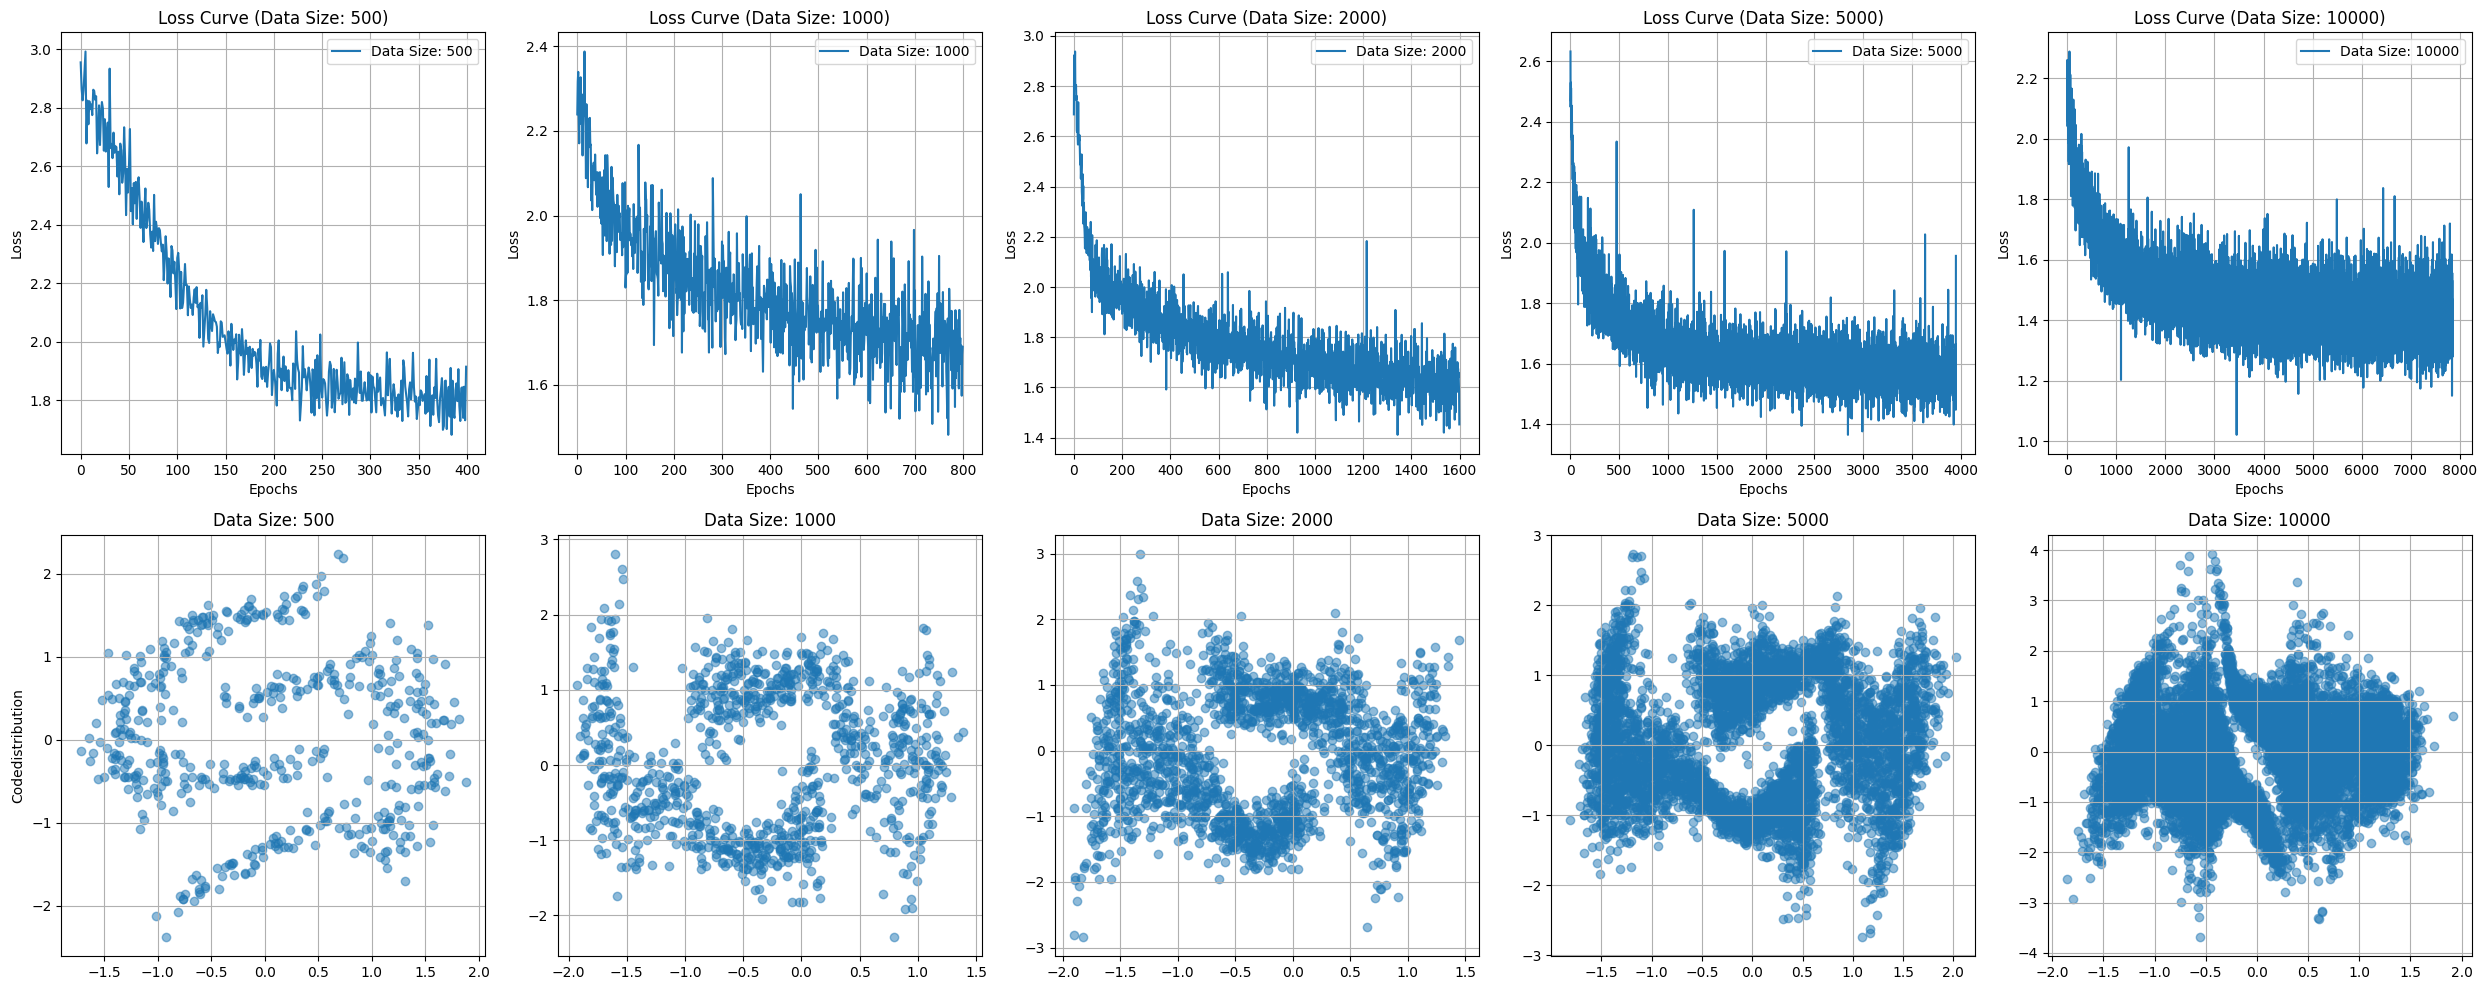

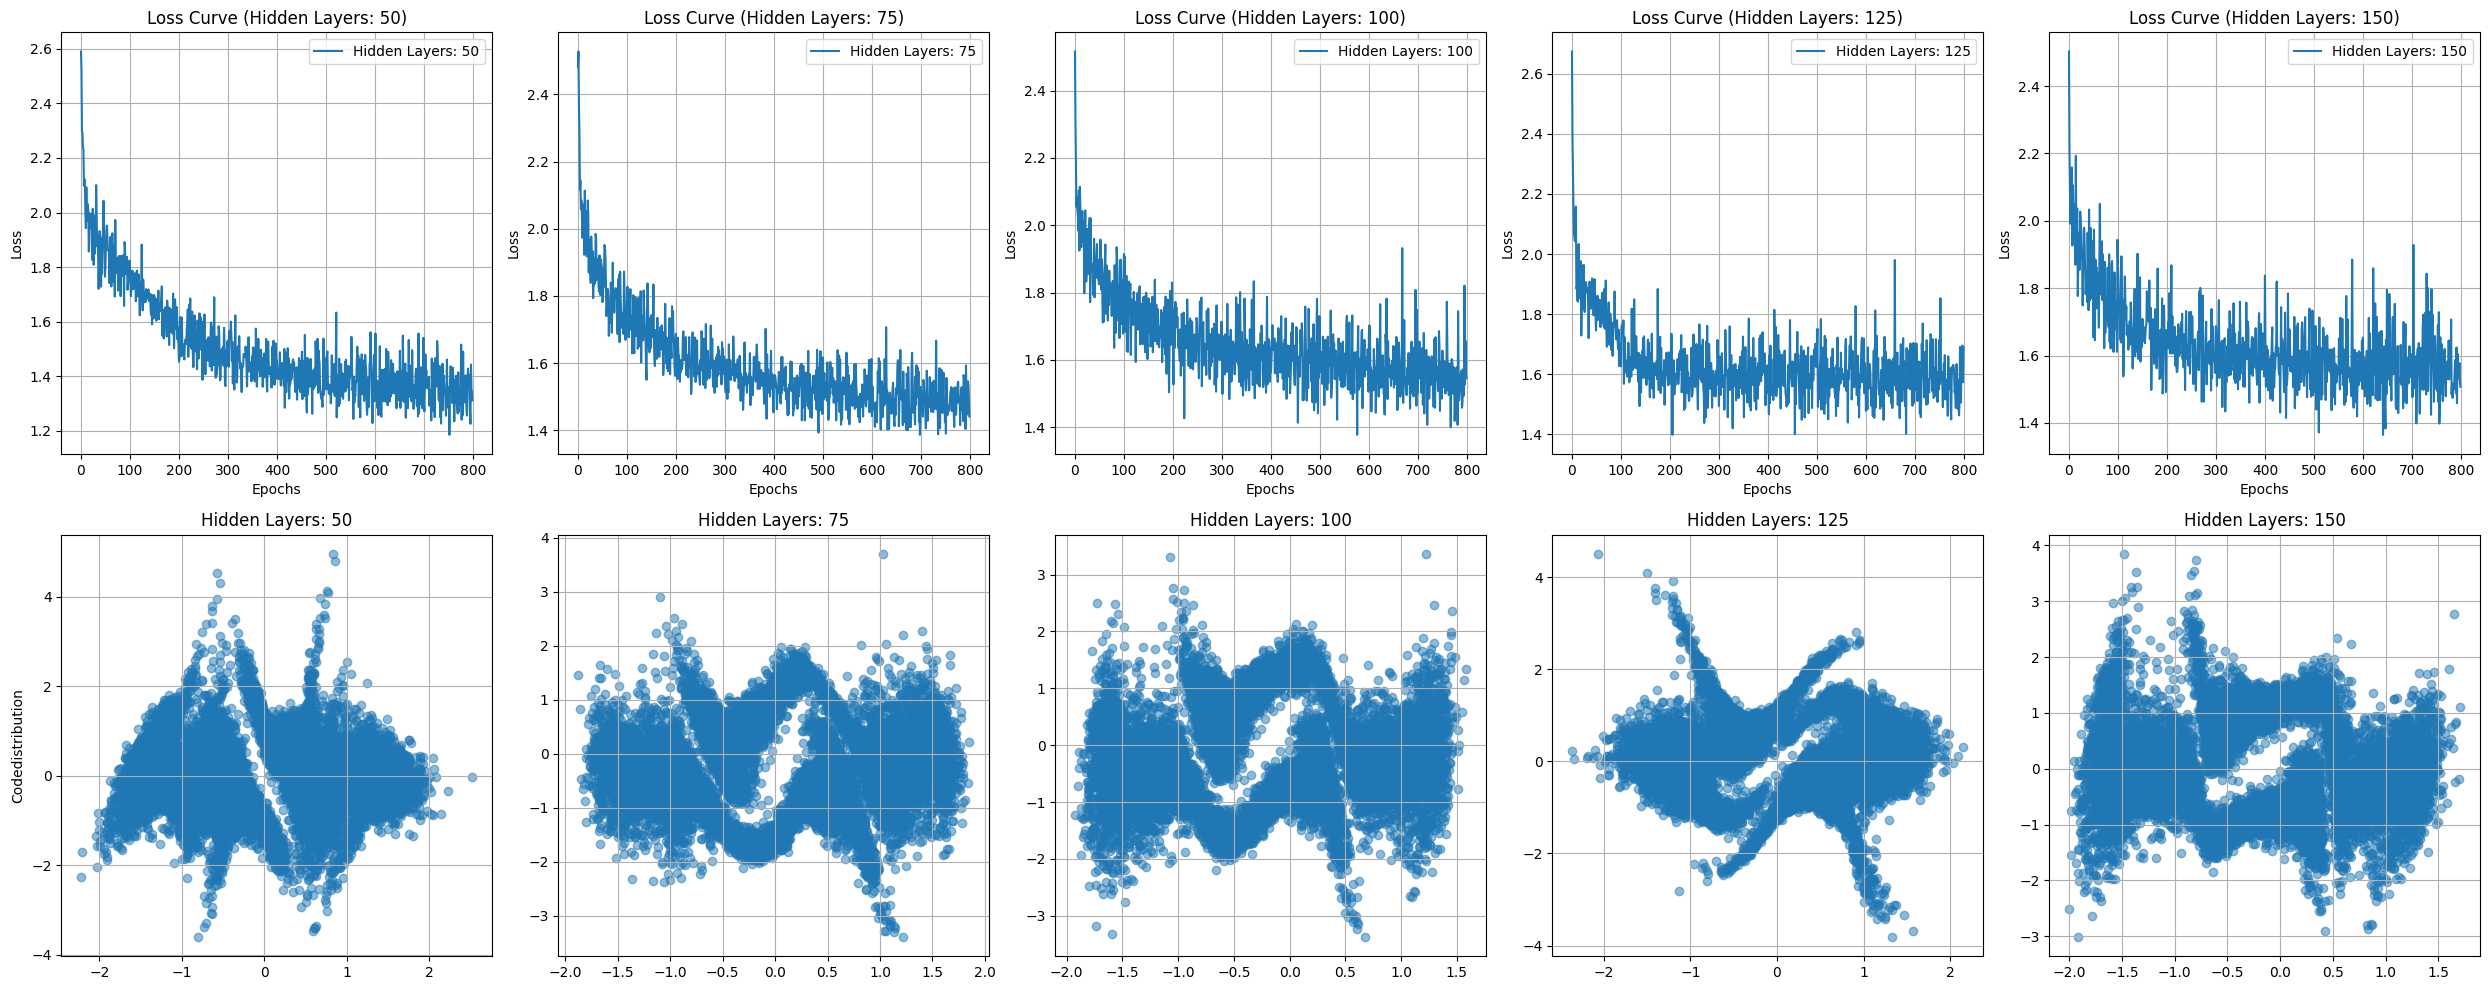

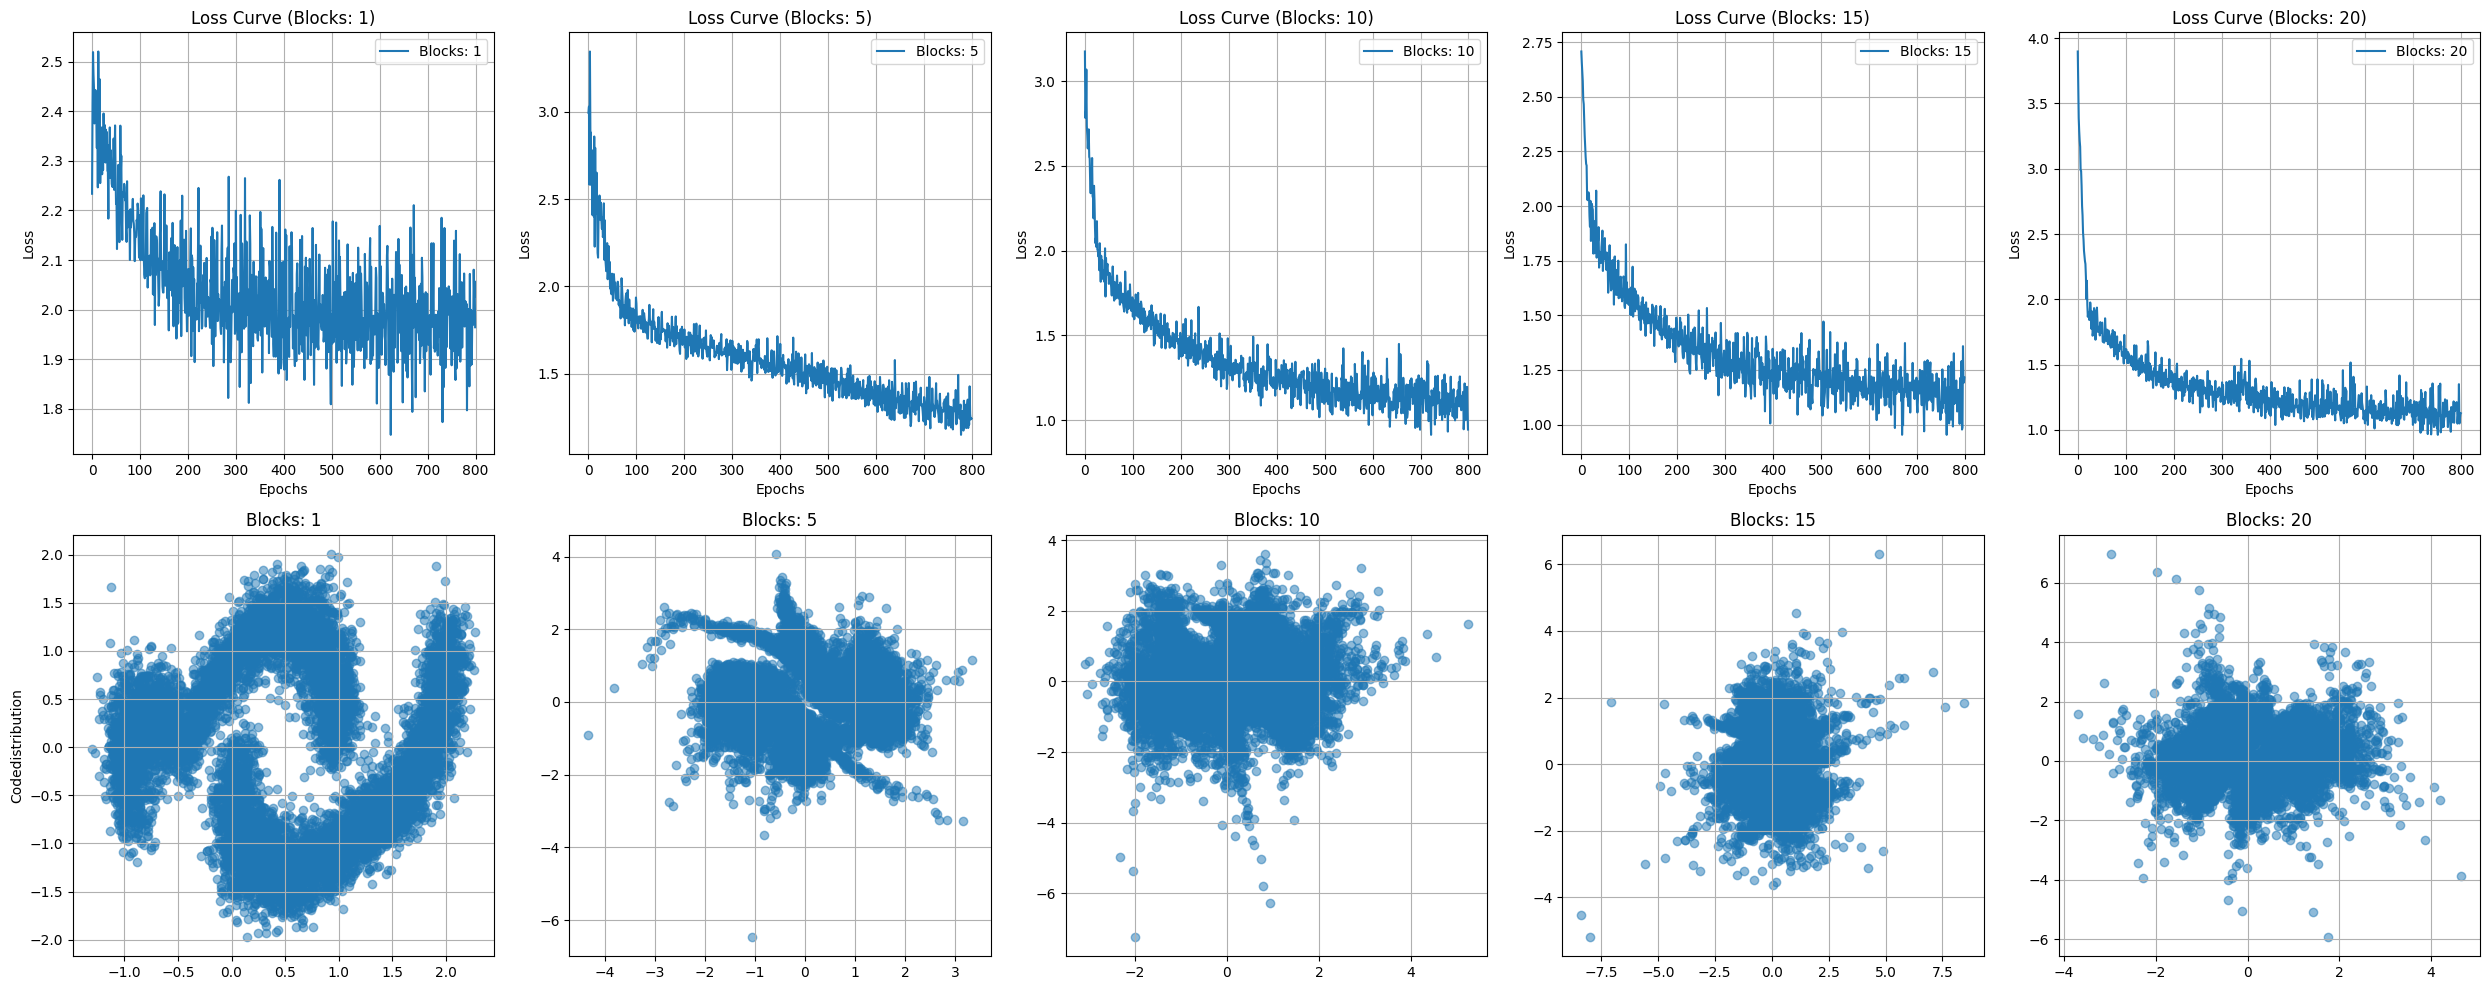

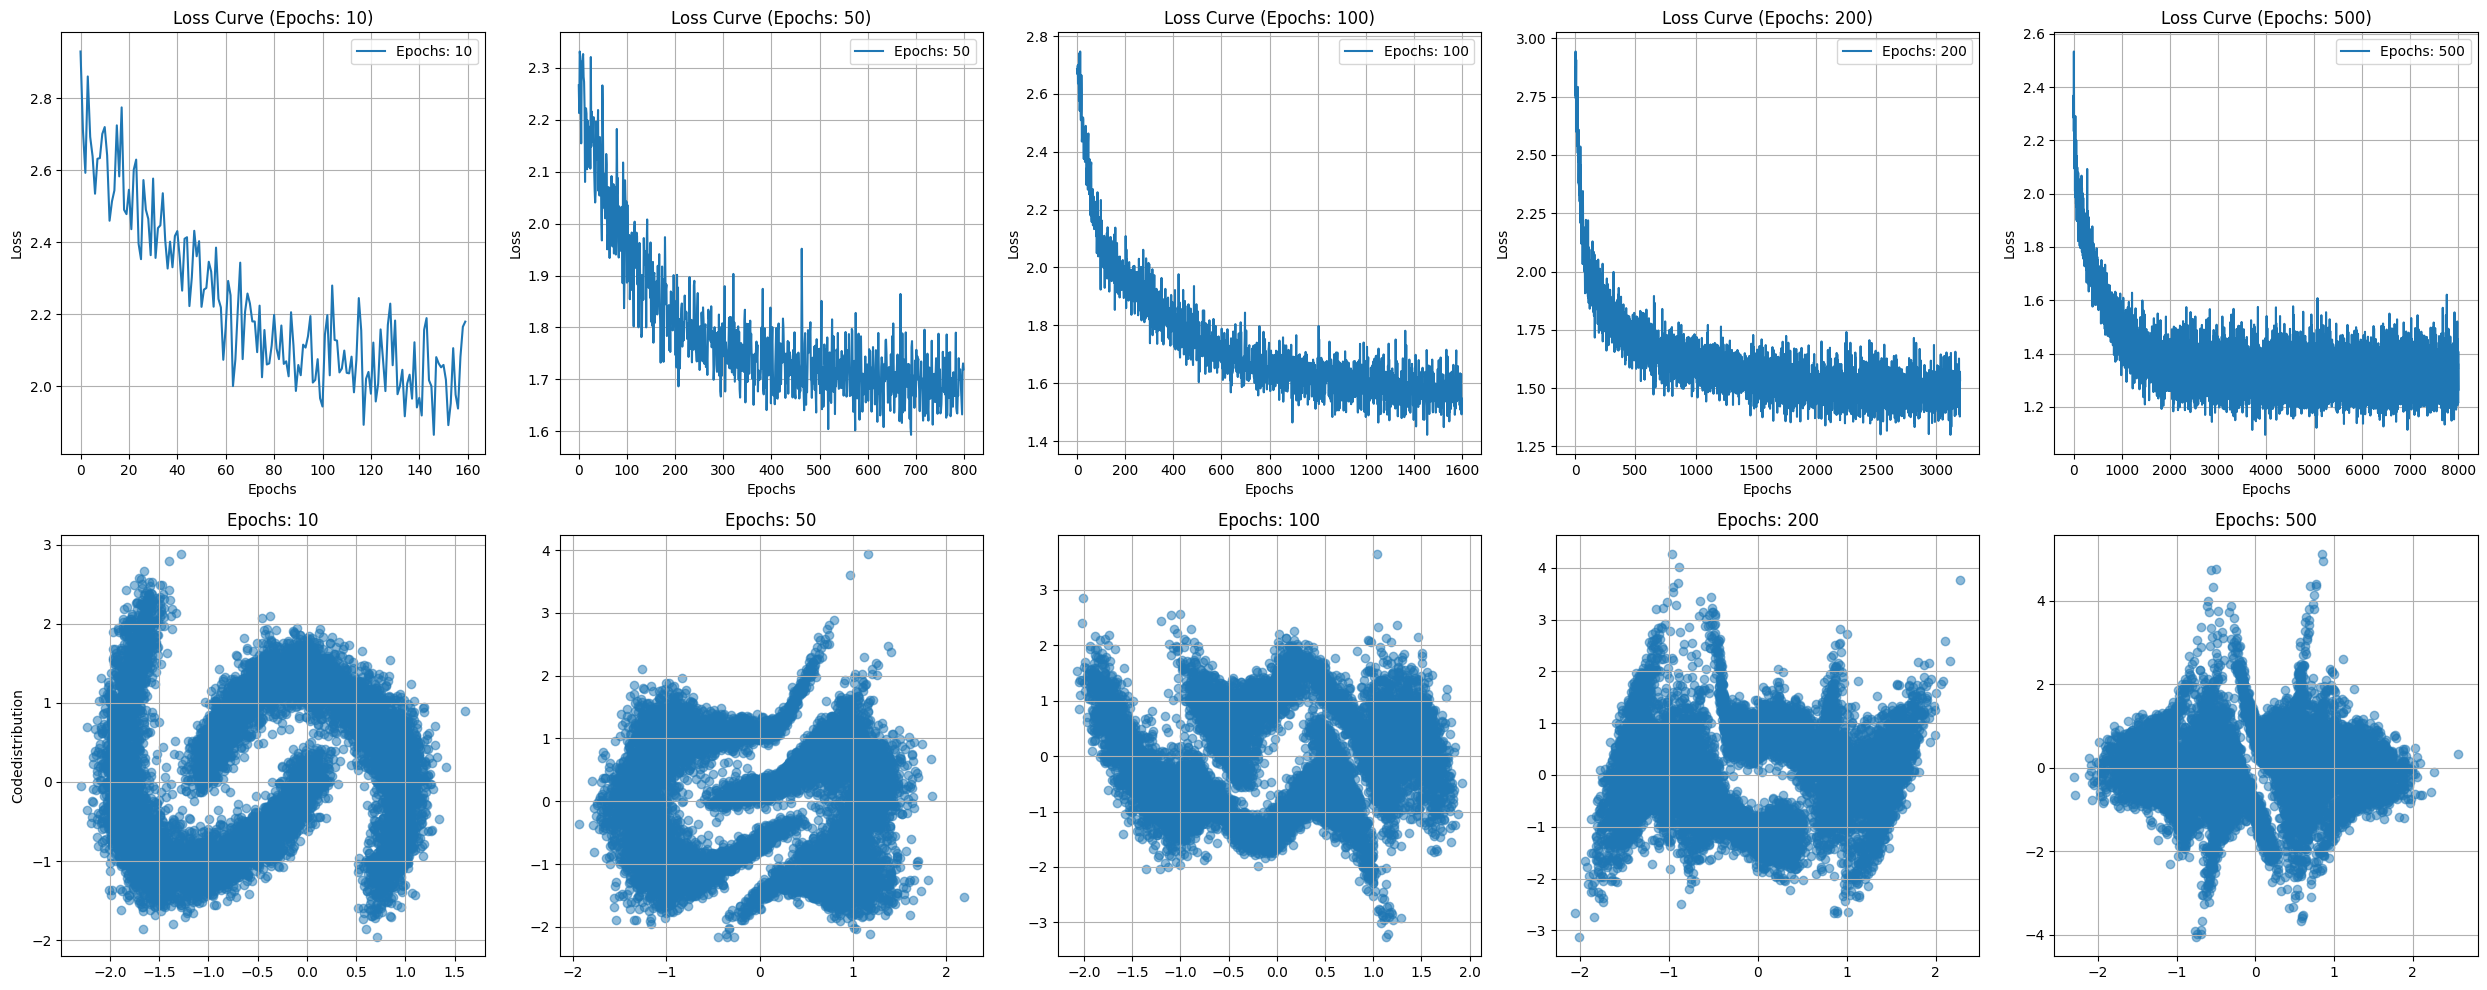

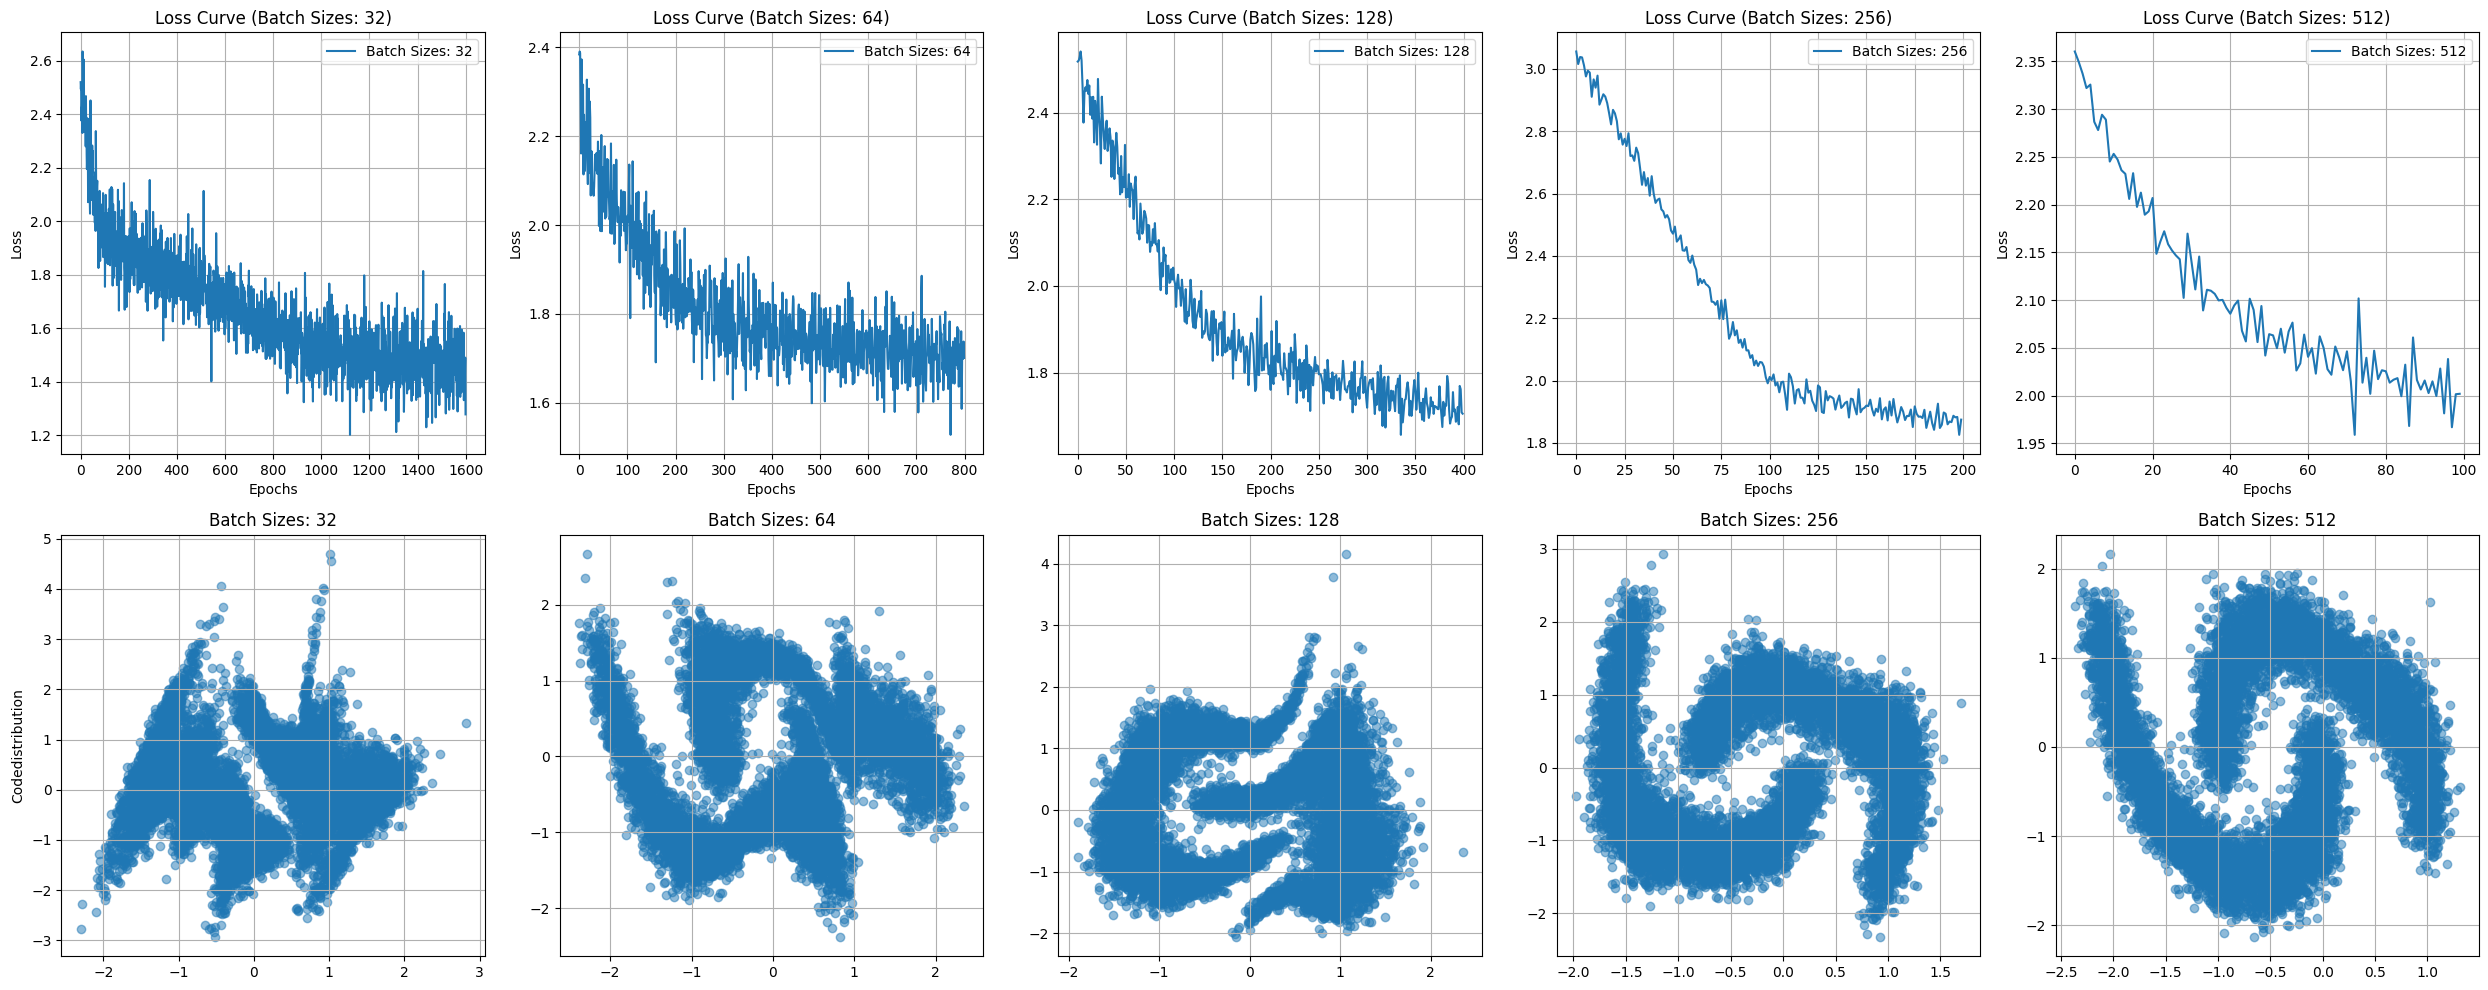

In [14]:
# Plot the data_size
plot_hyperparameter_results(
    data_size_results, 
    hyperparameter_values=data_size, 
    hyperparameter_name="Data Size"
)

# Plot the hidden size
plot_hyperparameter_results(
    hidden_size_result, 
    hyperparameter_values=hidden_size,
    hyperparameter_name="Hidden Layers"
)

# Plot the blocks
plot_hyperparameter_results(
    blocks_result, 
    hyperparameter_values=blocks, 
    hyperparameter_name="Blocks"
)

# plot the epochs
plot_hyperparameter_results(
    epochs_results, 
    hyperparameter_values=epochs, 
    hyperparameter_name="Epochs"
)
# plot batch sizes
plot_hyperparameter_results(
    batches_results, 
    hyperparameter_values=batch_sizes, 
    hyperparameter_name="Batch Sizes"
) 


In [15]:
# Good hyperparameters are:
data_size_good = 3000
blocks_good = 10
hidden_size_good = 100
epochs_good = 200
batch_sizes_good = 128



In [16]:
data_bad, _ = make_moons(n_samples=500, noise=0.1)
data_bad_tensor = torch.tensor(data_bad, device=device).float()

data_good , _ = make_moons(n_samples=data_size_good, noise=0.1)
data_good_tensor = torch.tensor(data_good, device=device).float()

# Train a model on good hyperparameters 

model_good = RealNVP(2, hidden_size=hidden_size_good, blocks=blocks_good, device=device)
train_inn(model_good, data_good_tensor, epochs=epochs_good, batch_size=batch_sizes_good)

# Train a model on bad hyperparamters for comparison

model_bad = RealNVP(2, 10, 2, device)
trainer = train_inn(model_bad, data_bad_tensor, epochs=50)

# just saved the trainer in a variable to avoid the print of the output, I don't know how to disable the function execution output in notebook 

In [17]:
# Helper function for MMD loss
def compute_mmd_loss(data, synthetic_data, bandwidth):
    x = data
    y = synthetic_data
    #normal_samples = torch.randn_like(codes)  # Reference distribution
    
    # Pairwise distances
    codes_distances = torch.cdist(x, x, p=2).pow(2)
    normal_distances = torch.cdist(y, y, p=2).pow(2)
    cross_distances = torch.cdist(x, y, p=2).pow(2)
    
    mmd_loss = 0.0
    
    kernel_codes = torch.exp(-codes_distances / (2.0 * bandwidth ** 2))
    kernel_normal = torch.exp(-normal_distances / (2.0 * bandwidth ** 2))
    kernel_cross = torch.exp(-cross_distances / (2.0 * bandwidth ** 2))
    
    # Compute MMD loss using kernel means
    mmd_loss += kernel_codes.mean() + kernel_normal.mean() - 2 * kernel_cross.mean()
    
    # Normaliz
    return mmd_loss


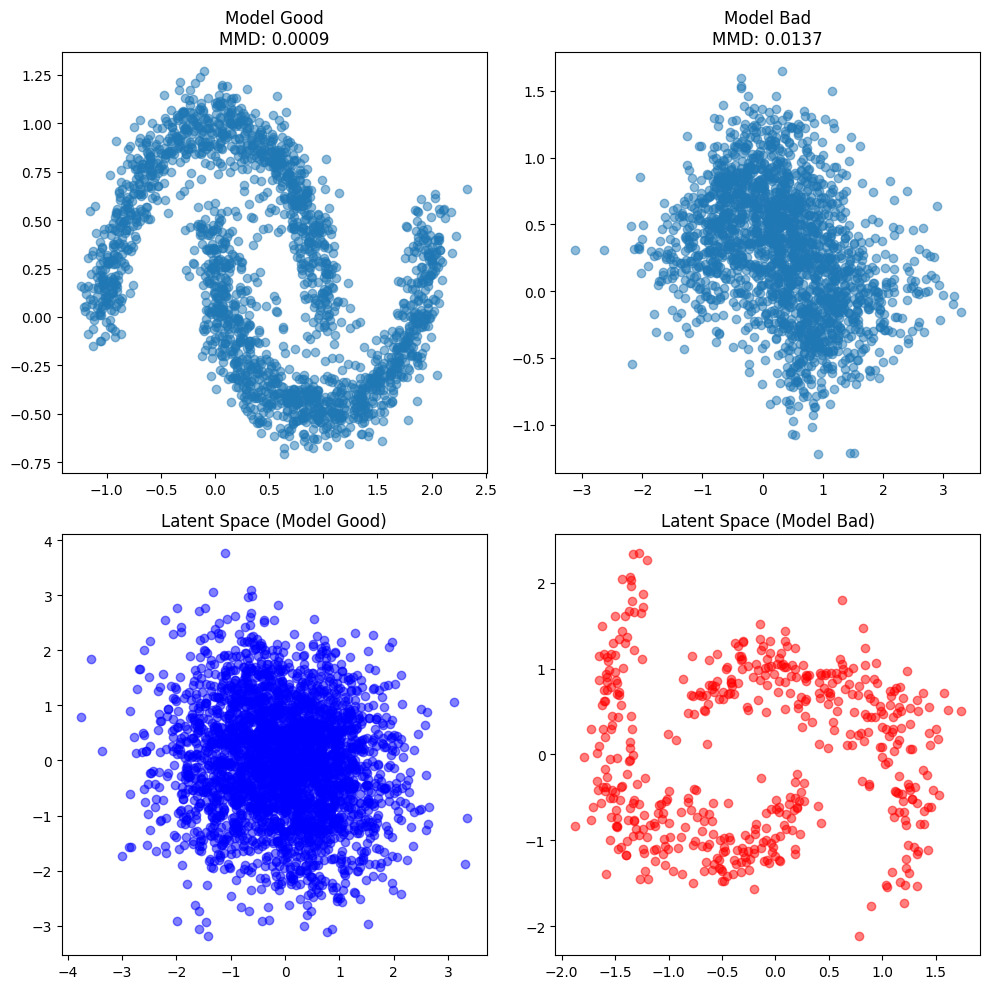

In [18]:
# Sample from the models
synthetic_data_good, _ = model_good.sample(2000, device)

synthetic_data_bad, _ = model_bad.sample(2000, device)

# Compute latent space representations
latent_good, _ = model_good.forward(data_good_tensor, reversed=False)
latent_bad, _ = model_bad.forward(data_bad_tensor, reversed=False)

# MMD 
mmd_good = compute_mmd_loss(data_good_tensor, synthetic_data_good, 0.1)
mmd_bad = compute_mmd_loss(data_bad_tensor, synthetic_data_bad, 0.1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Row 1: Original and synthetic data

# Model good
axs[0, 0].scatter(synthetic_data_good[:, 0].cpu().detach().numpy(), synthetic_data_good[:, 1].cpu().detach().numpy(), alpha=0.5)
axs[0, 0].set_title(f"Model Good\nMMD: {mmd_good:.4f}")

# Model bad
axs[0, 1].scatter(synthetic_data_bad[:, 0].cpu().detach().numpy(), synthetic_data_bad[:, 1].cpu().detach().numpy(), alpha=0.5)
axs[0, 1].set_title(f"Model Bad\nMMD: {mmd_bad:.4f}")

# Row 2: Latent space visualizations
# Latent space for model good
axs[1, 0].scatter(latent_good[:, 0].cpu().detach().numpy(), latent_good[:, 1].cpu().detach().numpy(), alpha=0.5, c="blue")
axs[1, 0].set_title("Latent Space (Model Good)")

# Latent space for model bad
axs[1, 1].scatter(latent_bad[:, 0].cpu().detach().numpy(), latent_bad[:, 1].cpu().detach().numpy(), alpha=0.5, c="red")
axs[1, 1].set_title("Latent Space (Model Bad)")

plt.tight_layout()
plt.show()

In [19]:
# Create GMM Hexagons

def hexagon_gmm_data(n_samples, radius):
    noise = radius / 10
    n_samples_per_component = n_samples // 6
    data = []
    for i in range(6):
        angle = i * np.pi / 3
        x = np.cos(angle) * radius
        y = np.sin(angle) * radius
        component = np.random.randn(n_samples_per_component, 2) * noise + np.array([x, y])
        data.append(component)
    data = np.concatenate(data, axis=0)
    return data

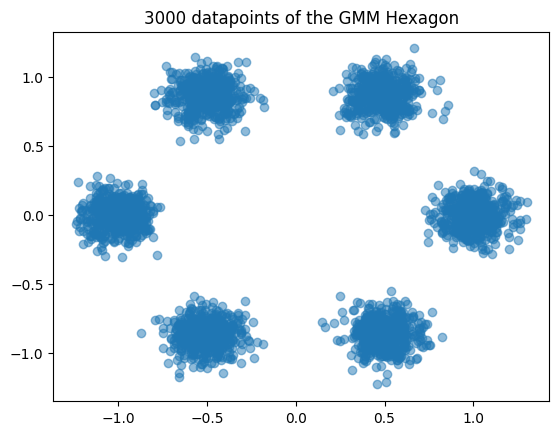

In [20]:
data_hexagon = hexagon_gmm_data(3000, 1)

plt.scatter(data_hexagon[:, 0], data_hexagon[:, 1], alpha=0.5)
plt.title('3000 datapoints of the GMM Hexagon')
plt.show()


In [21]:
# Train a model on the GMM
data_hexagon_tensor = torch.tensor(data_hexagon, dtype=torch.float32, device=device)

model_gmm = RealNVP(2, hidden_size=hidden_size_good, blocks=blocks_good, device=device)

trainer = train_inn(model_gmm, data_hexagon_tensor, epochs=epochs_good, batch_size=batch_sizes_good)

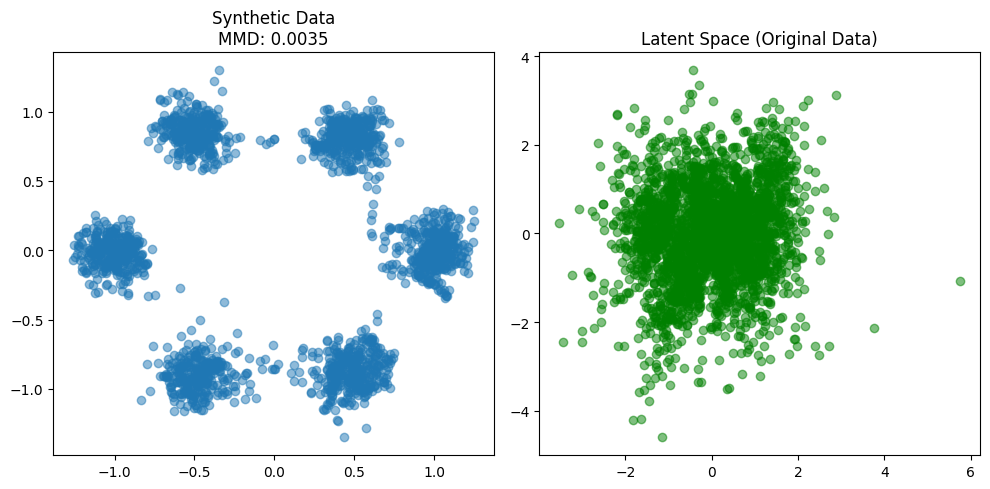

In [22]:
# Sample from the model
synthetic_data_gmm, _ = model_gmm.sample(2000, device)

# Compute latent space representation of synthetic data
latent_space_synthetic, _ = model_gmm.forward(data_hexagon_tensor, reversed=False)

# MMD
mmd_gmm = compute_mmd_loss(data_hexagon_tensor, synthetic_data_gmm, 0.1)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot synthetic data
axs[0].scatter(synthetic_data_gmm[:, 0].cpu().detach().numpy(), synthetic_data_gmm[:, 1].cpu().detach().numpy(), alpha=0.5)
axs[0].set_title(f"Synthetic Data\nMMD: {mmd_gmm:.4f}")

# Plot latent space
axs[1].scatter(latent_space_synthetic[:, 0].cpu().detach().numpy(), latent_space_synthetic[:, 1].cpu().detach().numpy(), alpha=0.5, c="green")
axs[1].set_title("Latent Space (Original Data)")

plt.tight_layout()
plt.show()

It seems like the GMM Hexagon shape is more difficult to learn, because the synthetic data is not as good as with the two moons, which used the same hyper parameters. Also the MMD is higher.


# Exercise 2

In [23]:
class CouplingLayerCond(nn.Module):
    def __init__(self, input_dim, conditonal_size, hidden_dim):
        super(CouplingLayerCond, self).__init__()
        self.input_dim = input_dim
        self.conditonal_size = conditonal_size

        self.s_net = nn.Sequential(
            nn.Linear(input_dim // 2 + conditonal_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )
        self.t_net = nn.Sequential(
            nn.Linear(input_dim // 2 + conditonal_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x, conditions=None, reversed=False):
        x1, x2 = x.chunk(2, dim=1)

        x1_cond = torch.cat([x1, conditions], dim=1)
        s = self.s_net(x1_cond)
        t = self.t_net(x1_cond)

        if reversed: # inverted pass
            x2 = (x2 - t) * torch.exp(-torch.tanh(s))
            det = - torch.sum(torch.tanh(s), dim=1)

        else: #normal pass 
            x2 = x2 * torch.exp(torch.tanh(s)) + t
            det = torch.sum(torch.tanh(s), dim=1)

        return torch.cat([x1, x2], dim=1), det

def rand_orthonormal(input_dim, device):
    q, _ = torch.linalg.qr(torch.randn(input_dim, input_dim, device=device))
    return q

class RealNVPCond(nn.Module):
    def __init__(self, input_size: int, condition_size: int=None, hidden_size: int=50, blocks: int=5, device: str='cpu'):
        super(RealNVPCond, self).__init__()
        self.device = device
        self.blocks = blocks
        self.input_size = input_size
        self.condition_size = condition_size
        self.coupling_blocks = nn.ModuleList()
        self.rotation_matrices = []
        
        for _ in range (blocks):
            self.coupling_blocks.append(CouplingLayerCond(input_size, condition_size, hidden_size))
            self.rotation_matrices.append(rand_orthonormal(input_size, device=device))

    def forward(self, x, conditions=None, reversed=False):
        tot_det = 0
        if reversed: 
            for i in range(self.blocks-1, -1, -1): # include 0
                # skip the first rotation matrix
                if i < self.blocks - 1:
                    x = x @ self.rotation_matrices[i].T
                x, det = self.coupling_blocks[i](x, conditions, reversed=True)
                tot_det += det 

        else: 
            for i in range(self.blocks):
                x, det = self.coupling_blocks[i](x, conditions)
                tot_det += det
                # skip the last rotation matrix
                if i < self.blocks - 1:
                    x = x @ self.rotation_matrices[i]

        return x, tot_det
    
    def sample(self, num_samples, conditions):
        samples = torch.randn(len(conditions), num_samples, self.input_size, device=self.device)
        conditions_expanded = conditions.unsqueeze(1).expand(-1, num_samples, -1).reshape(-1, self.condition_size)
        samples = samples.reshape(-1, self.input_size)
        samples, _ = self.forward(samples, conditions_expanded, reversed=True)
        return samples.view(len(conditions), num_samples, self.input_size)
    
    def decoder(self, z, conditions, k):
        z[:, k:] = 0
        conditions[:, k:] = 0
        reconstructed, _ = self.forward(z, conditions, reversed=True)
        return reconstructed

In [24]:
def train_inn_cond(model, data, labels, epochs=100, lr=0.001, batch_size=64): 
    model = model.to(device)
    
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(model.input_size).to(device),
        torch.eye(model.input_size).to(device)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)

    data_loader = torch.utils.data.DataLoader(list(zip(data, labels)), batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in range(epochs):
        for x in data_loader:
            data_batch = x[0].to(device)
            label_batch = x[1].to(device)
            one_hot_labels = nn.functional.one_hot(label_batch.long(), num_classes=model.condition_size).float()
            x_hat, det = model.forward(data_batch, one_hot_labels)
            log_p = dist.log_prob(x_hat)
            loss = -(log_p + det).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        #print(f'Epoch : {epoch} done')
    return losses

In [25]:
# Train a model on the two moons with labels
data, labels = make_moons(n_samples=3000, noise=0.1)

data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(labels, dtype=torch.float32).to(device)

model = RealNVPCond(input_size=2, condition_size=2, hidden_size=hidden_size_good, blocks=blocks_good, device=device)
trainer = train_inn_cond(model, data_tensor, labels_tensor, epochs=epochs_good, batch_size=batch_sizes_good)

/tmp/ipykernel_32329/1336235838.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", model.condition_size)


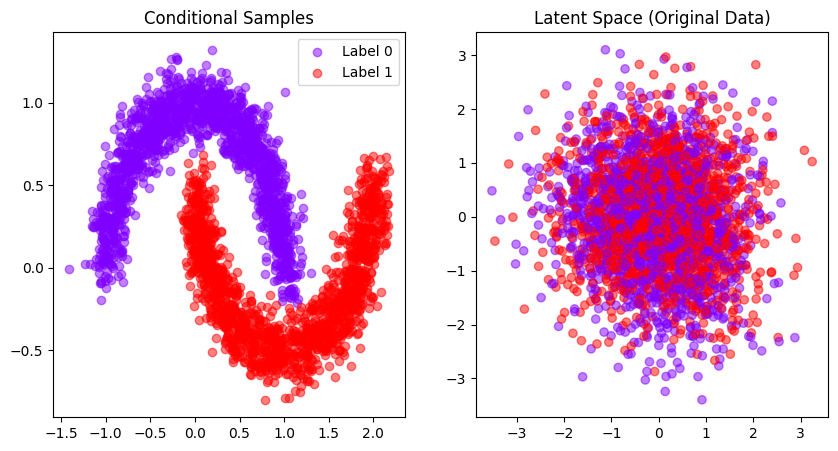

In [26]:
# Sampling conditioned on each label
colormap = cm.get_cmap("rainbow", model.condition_size)

labels = torch.arange(model.condition_size, device=model.device)
conditions = torch.nn.functional.one_hot(labels, num_classes=model.condition_size).float()
samples = model.sample(1500, conditions)

labels_onehot = torch.nn.functional.one_hot(labels_tensor.long(), num_classes=model.condition_size).float()
latent_space_moons_cond, _ = model.forward(data_tensor, conditions=labels_onehot, reversed=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Visualize each conditional distribution
for i, label_samples in enumerate(samples):
    color = colormap(i)
    axs[0].scatter(label_samples[:, 0].cpu().detach().numpy(), label_samples[:, 1].cpu().detach().numpy(), label=f"Label {i}", alpha=0.5, color=color)
axs[0].set_title("Conditional Samples")
axs[0].legend()
axs[1].scatter(latent_space_moons_cond[:, 0].cpu().detach().numpy(), latent_space_moons_cond[:, 1].cpu().detach().numpy(), c=labels_tensor.cpu(), alpha=0.5, cmap=colormap)
axs[1].set_title("Latent Space (Original Data)")
plt.show()


In [27]:
# Merge labeled samples and compute mmd loss
labeled_samples = torch.cat([label_samples for label_samples in samples], dim=0)
mmd_labeled = compute_mmd_loss(data_tensor, labeled_samples, 0.1)

print(f'The mmd for the conditional samples trained on the same hyperparameters is: {mmd_labeled:.4f}')

The mmd for the conditional samples trained on the same hyperparameters is: 0.0006


In [28]:
# Update the GMM Function to include labels
def hexagon_gmm_data(n_samples, radius=1):
    noise = radius / 10
    n_samples_per_component = n_samples // 6
    data = []
    
    label_encoding = np.zeros(6, dtype=int)
    indices = np.random.choice(6, size=2, replace=False)
    label_encoding[indices] = 1
    labels = []
    for i in range(6):
        angle = i * np.pi / 3
        x = np.cos(angle) * radius
        y = np.sin(angle) * radius
        component = np.random.randn(n_samples_per_component, 2) * noise + np.array([x, y])

        if label_encoding[i] == 1:
            labels.append(np.ones(n_samples_per_component))
        else:
            labels.append(np.zeros(n_samples_per_component))
        data.append(component)
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels)
    return data, labels

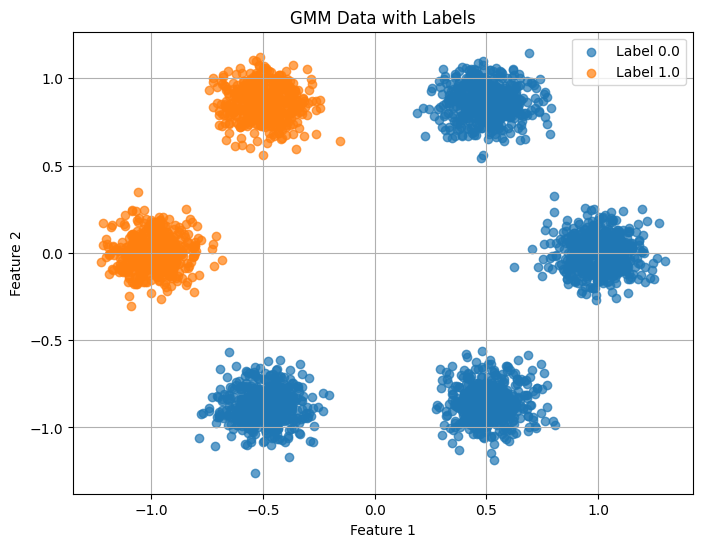

In [29]:
data, labels = hexagon_gmm_data(n_samples=3000, radius=1)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(data[idx, 0], data[idx, 1], label=f"Label {label}", alpha=0.7)

plt.title("GMM Data with Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Train a model on the GMM with labeling 

data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(labels, dtype=torch.float32).to(device)

model = RealNVPCond(input_size=2, condition_size=2, hidden_size=hidden_size_good, blocks=blocks_good, device=device)

trainer = train_inn_cond(model, data_tensor, labels_tensor, epochs=epochs_good, batch_size=batch_sizes_good)


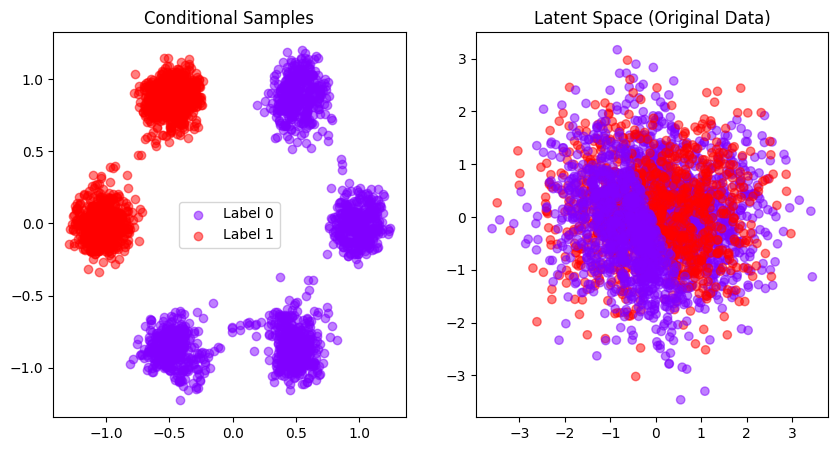

In [31]:

# Sampling conditioned on each label
labels = torch.arange(model.condition_size, device=model.device)
conditions = torch.nn.functional.one_hot(labels, num_classes=model.condition_size).float()
samples = model.sample(1500, conditions)

labels_onehot = torch.nn.functional.one_hot(labels_tensor.long(), num_classes=model.condition_size).float()
latent_space_gmm_cond, _ = model.forward(data_tensor, conditions=labels_onehot, reversed=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Visualize each the sampled data
for i, label_samples in enumerate(samples):
    color = colormap(i)
    axs[0].scatter(label_samples[:, 0].cpu().detach().numpy(), label_samples[:, 1].cpu().detach().numpy(), label=f"Label {i}", alpha=0.5, color=color)
axs[0].set_title("Conditional Samples")
axs[0].legend()
axs[1].scatter(latent_space_gmm_cond[:, 0].cpu().detach().numpy(), latent_space_gmm_cond[:, 1].cpu().detach().numpy(), c=labels_tensor.cpu(), alpha=0.5, cmap=colormap)
axs[1].set_title("Latent Space (Original Data)")
plt.show()

In [32]:
# Print the MMD loss
labeled_samples = torch.cat([label_samples for label_samples in samples], dim=0)
mmd_labeled = compute_mmd_loss(data_tensor, labeled_samples, 0.1)
print(f'The mmd for the conditional samples trained on the same hyperparameters is: {mmd_labeled:.4f}')


The mmd for the conditional samples trained on the same hyperparameters is: 0.0100


# Exercise 3

In [33]:
# load the digits dataset 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


digits = load_digits()
# split the data into training and test sets
digits_data_train, digits_data_test, digits_labels_train, digits_labels_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42, stratify=digits.target)


digits_data_tensor = torch.tensor(digits_data_train, dtype=torch.float32).to(device)
digits_labels_tensor = torch.tensor(digits_labels_train, dtype=torch.float32).to(device)

digits_test_labels = torch.tensor(digits_labels_test, dtype=torch.float32).to(device)
digits_test_data = torch.tensor(digits_data_test, dtype=torch.float32).to(device)


In [34]:
# default hyperparameters
default_hidden_size = 10
default_blocks = 2
default_epochs = 50
default_batch_size = 64

# Investigate model quality on hyperparamters 
epochs = [10, 50, 100, 200, 500]
blocks = [1, 5, 10, 15, 20]
hidden_size = [50, 75, 100, 125, 150]
batch_sizes = [32, 64, 128, 256, 512]

# Empty results
epochs_results = {'losses': [], 'distribution': []}
blocks_result = {'losses': [], 'distribution': []}
hidden_size_result = {'losses': [], 'distribution': []}
batches_results = {'losses': [], 'distribution': []}


In [35]:
# Loop over different hyperparameters
print("Starting training of Epochs")
for i in epochs:

    model = RealNVP(64, default_hidden_size, default_blocks, device)
    test = train_inn(model=model, data=digits_data_tensor, epochs=i)
    distribution = model.forward(digits_test_data, reversed=False)
    epochs_results['losses'].append(test)
    epochs_results['distribution'].append(distribution)
    print(f"Number of Epochs: {i} done")

Starting training of Epochs
Number of Epochs: 10 done
Number of Epochs: 50 done
Number of Epochs: 100 done
Number of Epochs: 200 done
Number of Epochs: 500 done


In [36]:
print('Starting training of Number of Blocks')
for i in blocks:
    # impact of data size on the model 
    model = RealNVP(64, default_hidden_size, i, device)
    test = train_inn(model=model, data=digits_data_tensor, epochs=default_epochs)
    distribution = model.forward(digits_test_data, reversed=False)
    blocks_result['losses'].append(test)
    blocks_result['distribution'].append(distribution)
    print(f"Number of blocks: {i} done")

Starting training of Number of Blocks
Number of blocks: 1 done
Number of blocks: 5 done
Number of blocks: 10 done
Number of blocks: 15 done
Number of blocks: 20 done


In [37]:
print("Starting training of different Hidden Sizes")
for i in hidden_size:

    model = RealNVP(64, i, default_blocks, device)
    test = train_inn(model=model, data=digits_data_tensor, epochs=default_epochs)
    distribution = model.forward(digits_test_data, reversed=False)
    hidden_size_result['losses'].append(test)
    hidden_size_result['distribution'].append(distribution)
    print(f"Hidden size: {i} done")

Starting training of different Hidden Sizes
Hidden size: 50 done
Hidden size: 75 done
Hidden size: 100 done
Hidden size: 125 done
Hidden size: 150 done


In [38]:
print("Starting training of Batch Sizes")
for i in batch_sizes: 

    model = RealNVP(64, default_hidden_size, default_blocks, device)
    test = train_inn(model=model, data=digits_data_tensor, epochs=default_epochs, batch_size=i)
    distribution = model.forward(digits_test_data, reversed=False)
    batches_results['losses'].append(test)
    batches_results['distribution'].append(distribution)
    print(f"Number of Batches: {i} done")

Starting training of Batch Sizes
Number of Batches: 32 done
Number of Batches: 64 done
Number of Batches: 128 done
Number of Batches: 256 done
Number of Batches: 512 done


In [39]:
# and this to plot with labels 
def plot_hyperparameter_results(results, hyperparameter_values, hyperparameter_name, labels):
    pca = PCA(n_components=2)

    fig, axes = plt.subplots(2, len(hyperparameter_values), figsize=(5 * len(hyperparameter_values), 10))

    # Loss curve
    for i, (loss_curve, param_value) in enumerate(zip(results['losses'], hyperparameter_values)):
        axes[0, i].plot(loss_curve, label=f"{hyperparameter_name}: {param_value}")
        axes[0, i].set_title(f"Loss Curve ({hyperparameter_name}: {param_value})")
        axes[0, i].set_xlabel("Epochs")
        axes[0, i].set_ylabel("Loss")
        axes[0, i].grid()
        axes[0, i].legend()

    # Original vs. reconstructed distribution
    axes[1, 0].set_ylabel("Code Distribution")
    for i, distribution in enumerate(results['distribution']):
        data, _ = distribution
        pca_data = pca.fit_transform(data.cpu().detach().numpy())

        # Plot points with colors based on labels
        unique_labels = np.unique(labels)
        for label in unique_labels:
            idx = labels == label
            axes[1, i].scatter(
                pca_data[idx, 0],
                pca_data[idx, 1],
                alpha=0.5,
                label=f"Label {label}"
            )

        axes[1, i].set_title(f"{hyperparameter_name}: {hyperparameter_values[i]}")
        axes[1, i].grid()
        axes[1, i].legend()

    fig.tight_layout()
    plt.show()


In [40]:
print(len(epochs_results['distribution']))
print(len(blocks_result['distribution']))
print(len(hidden_size_result['distribution']))
print(len(batches_results['distribution']))

5
5
5
5


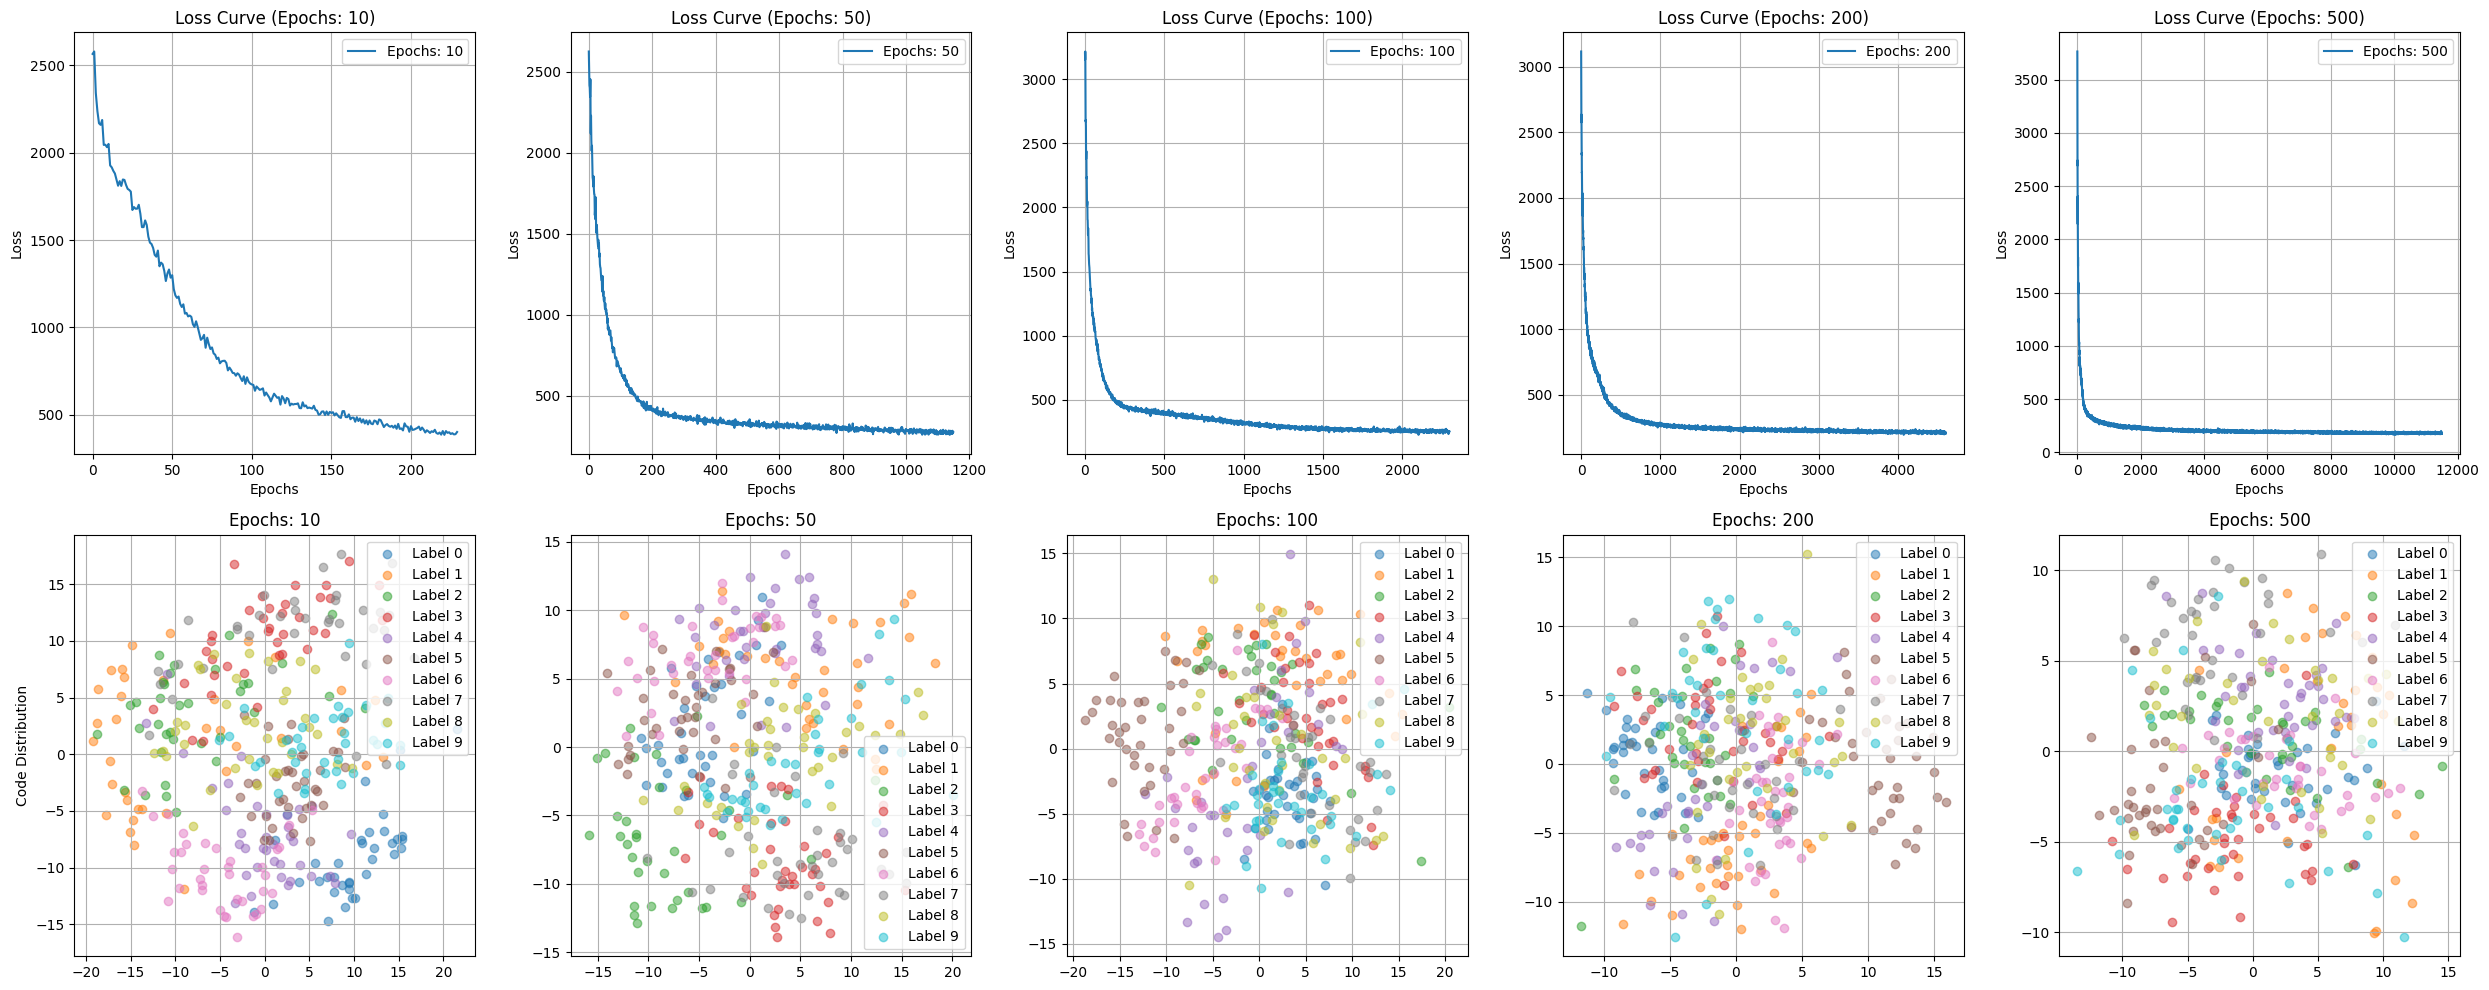

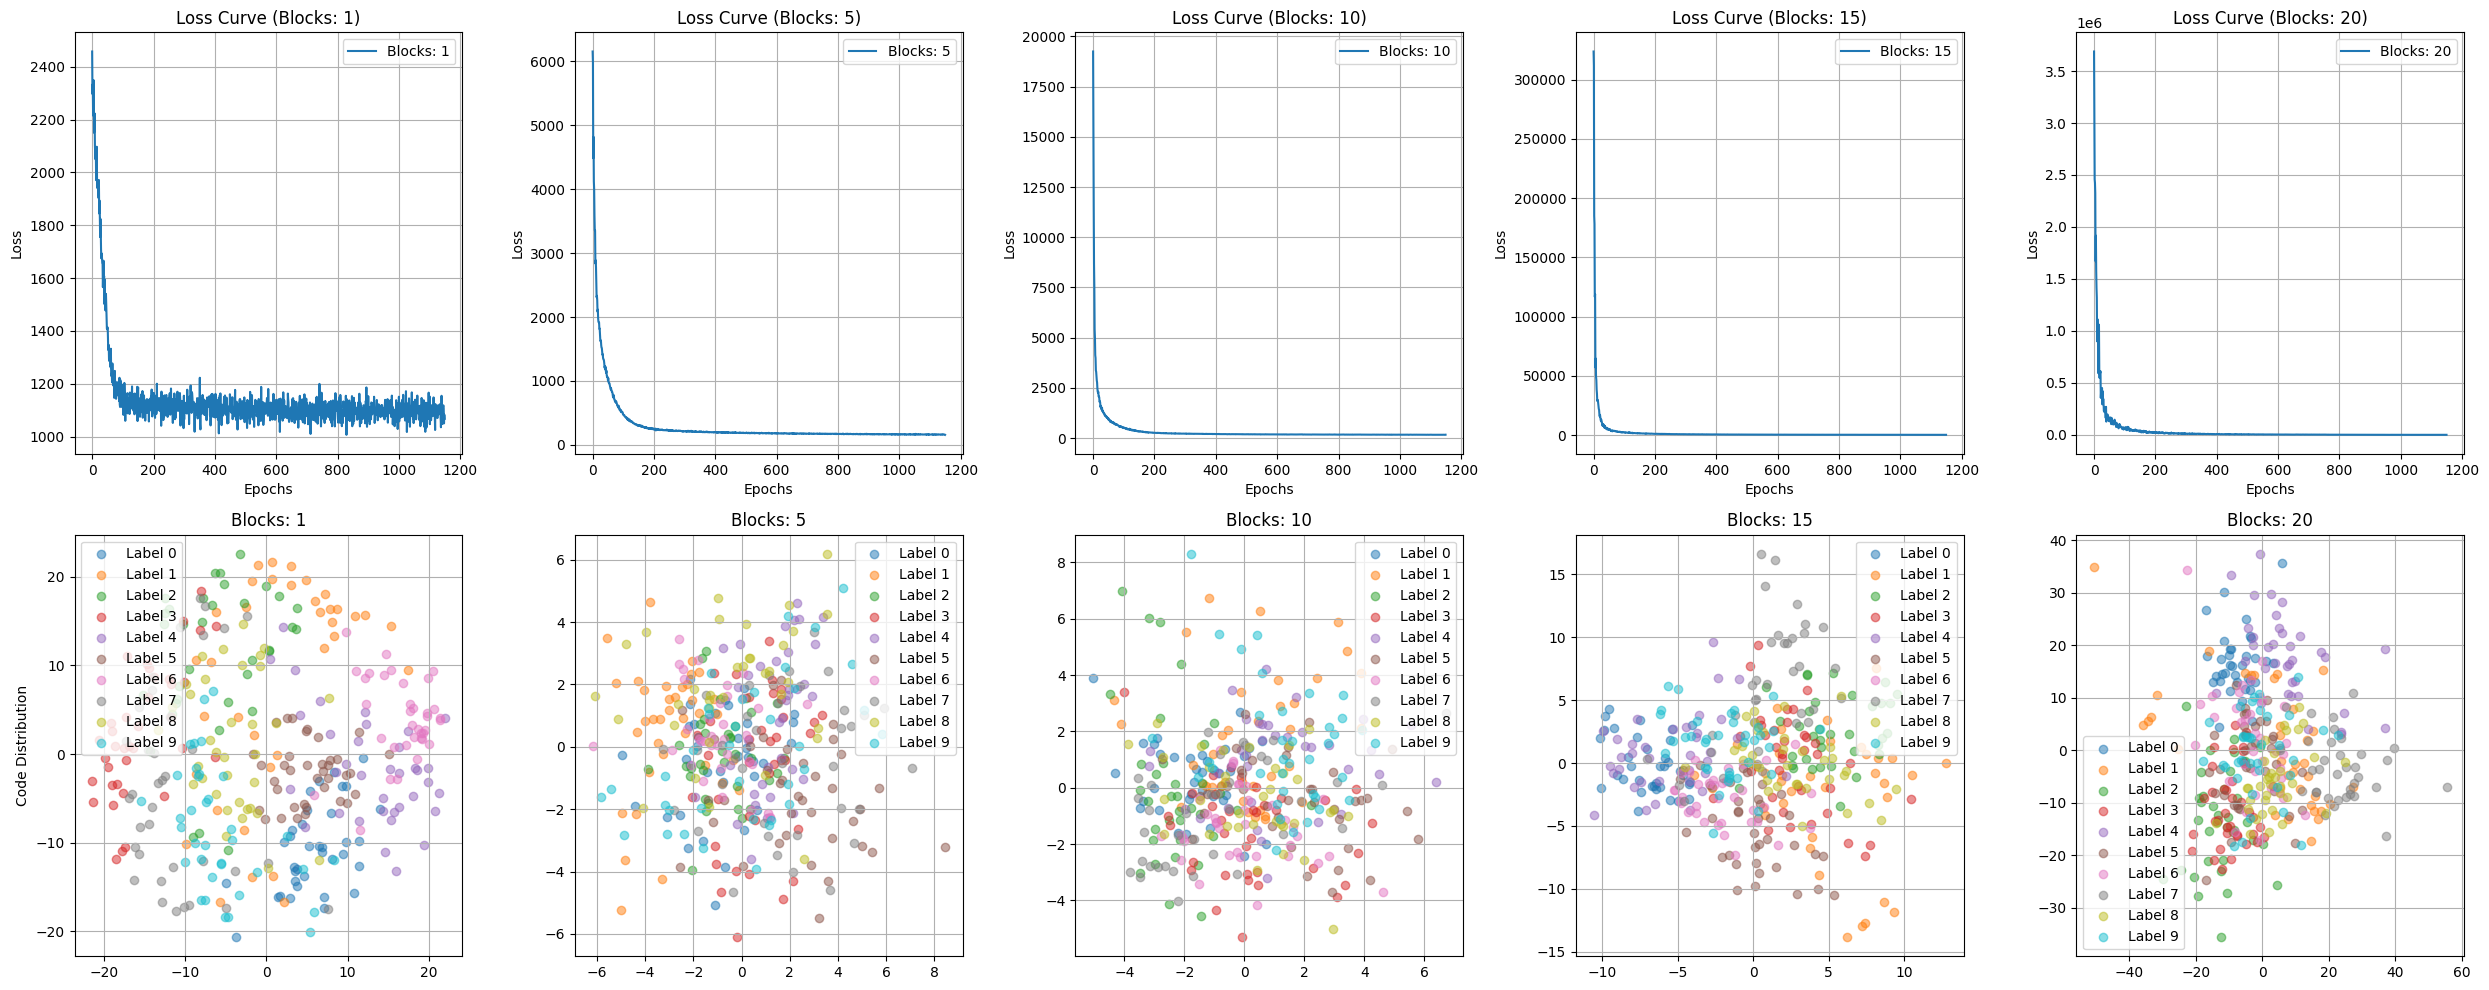

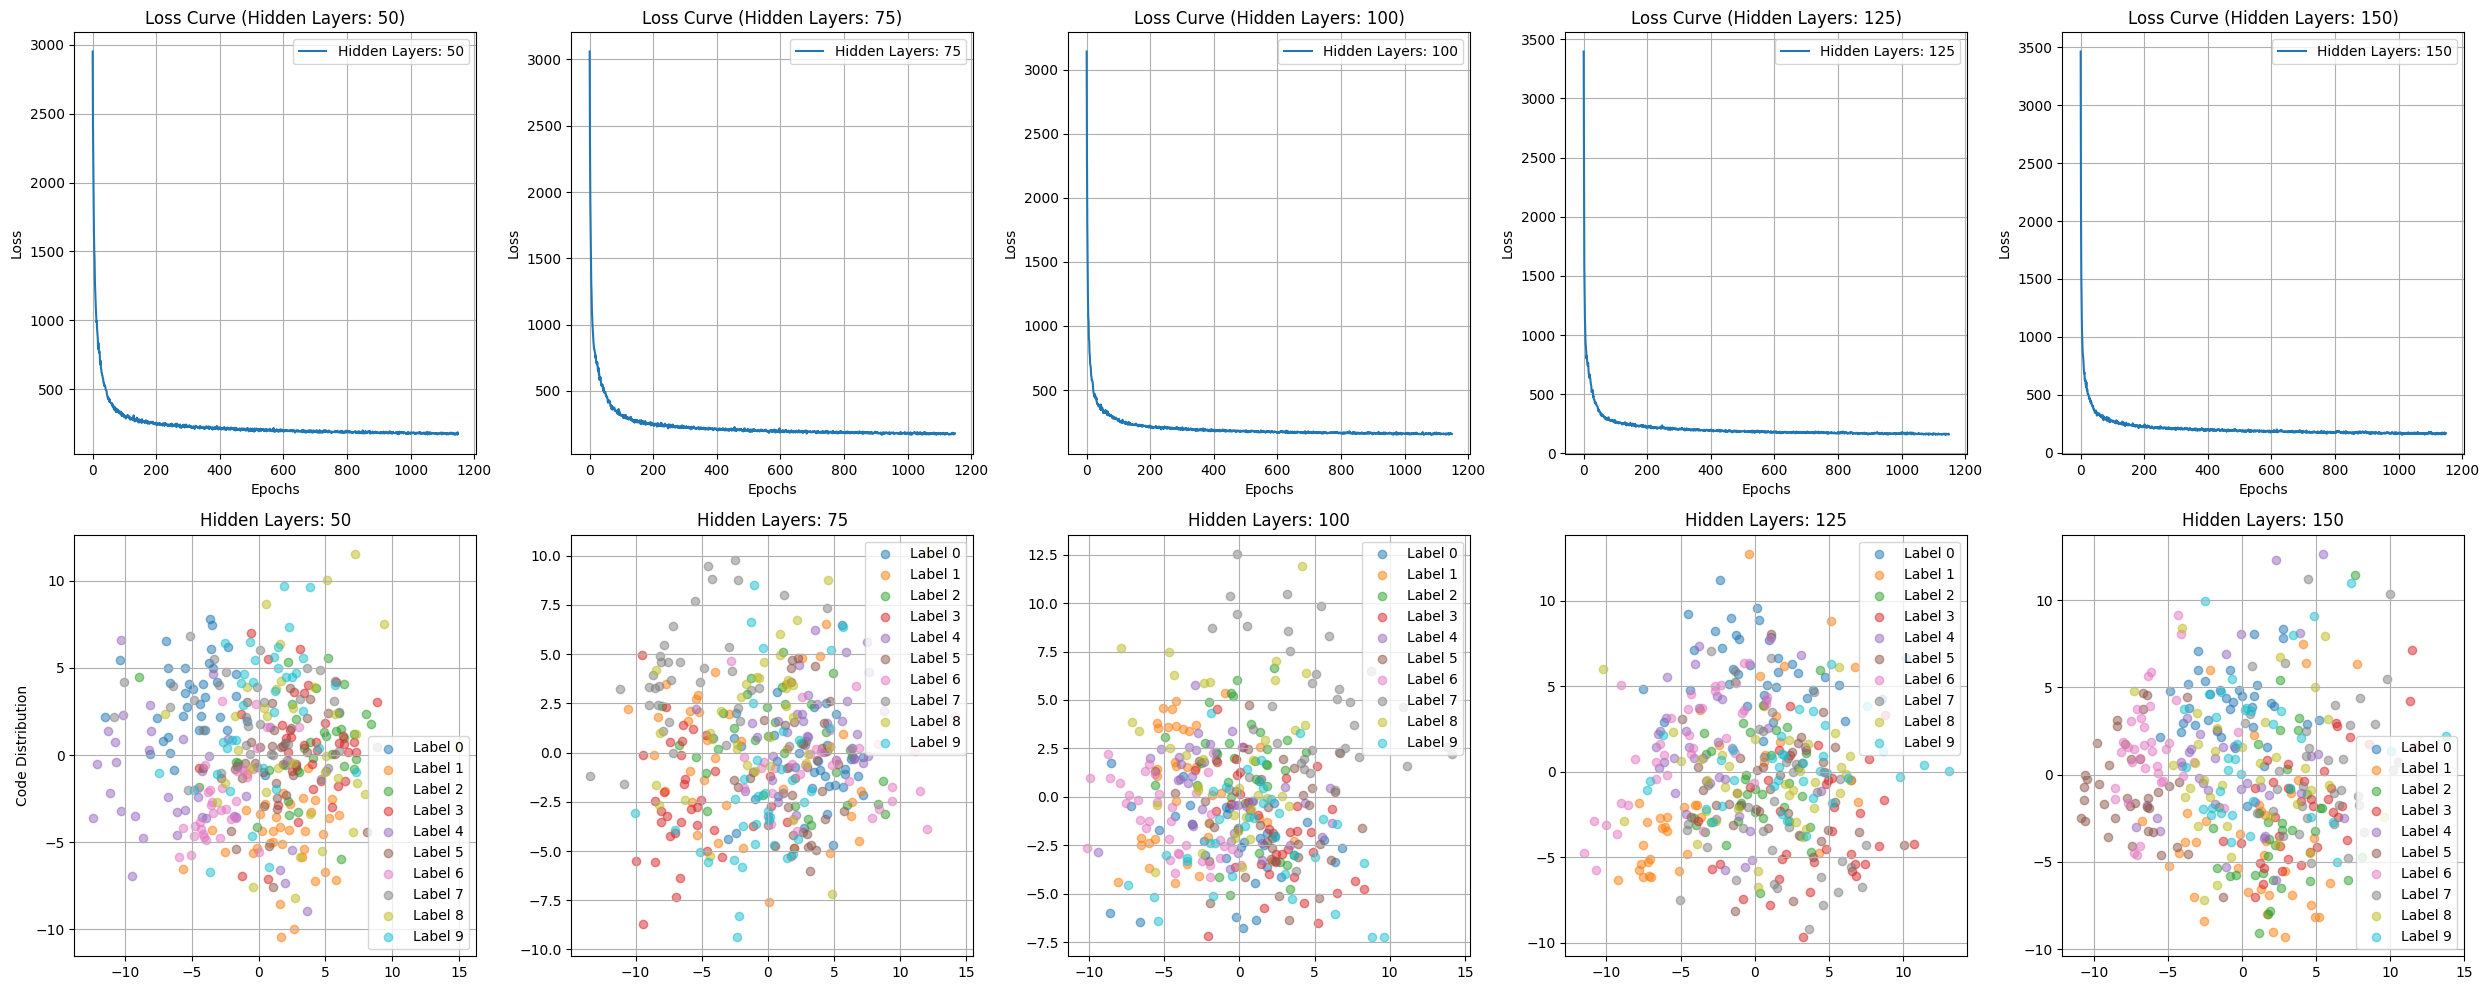

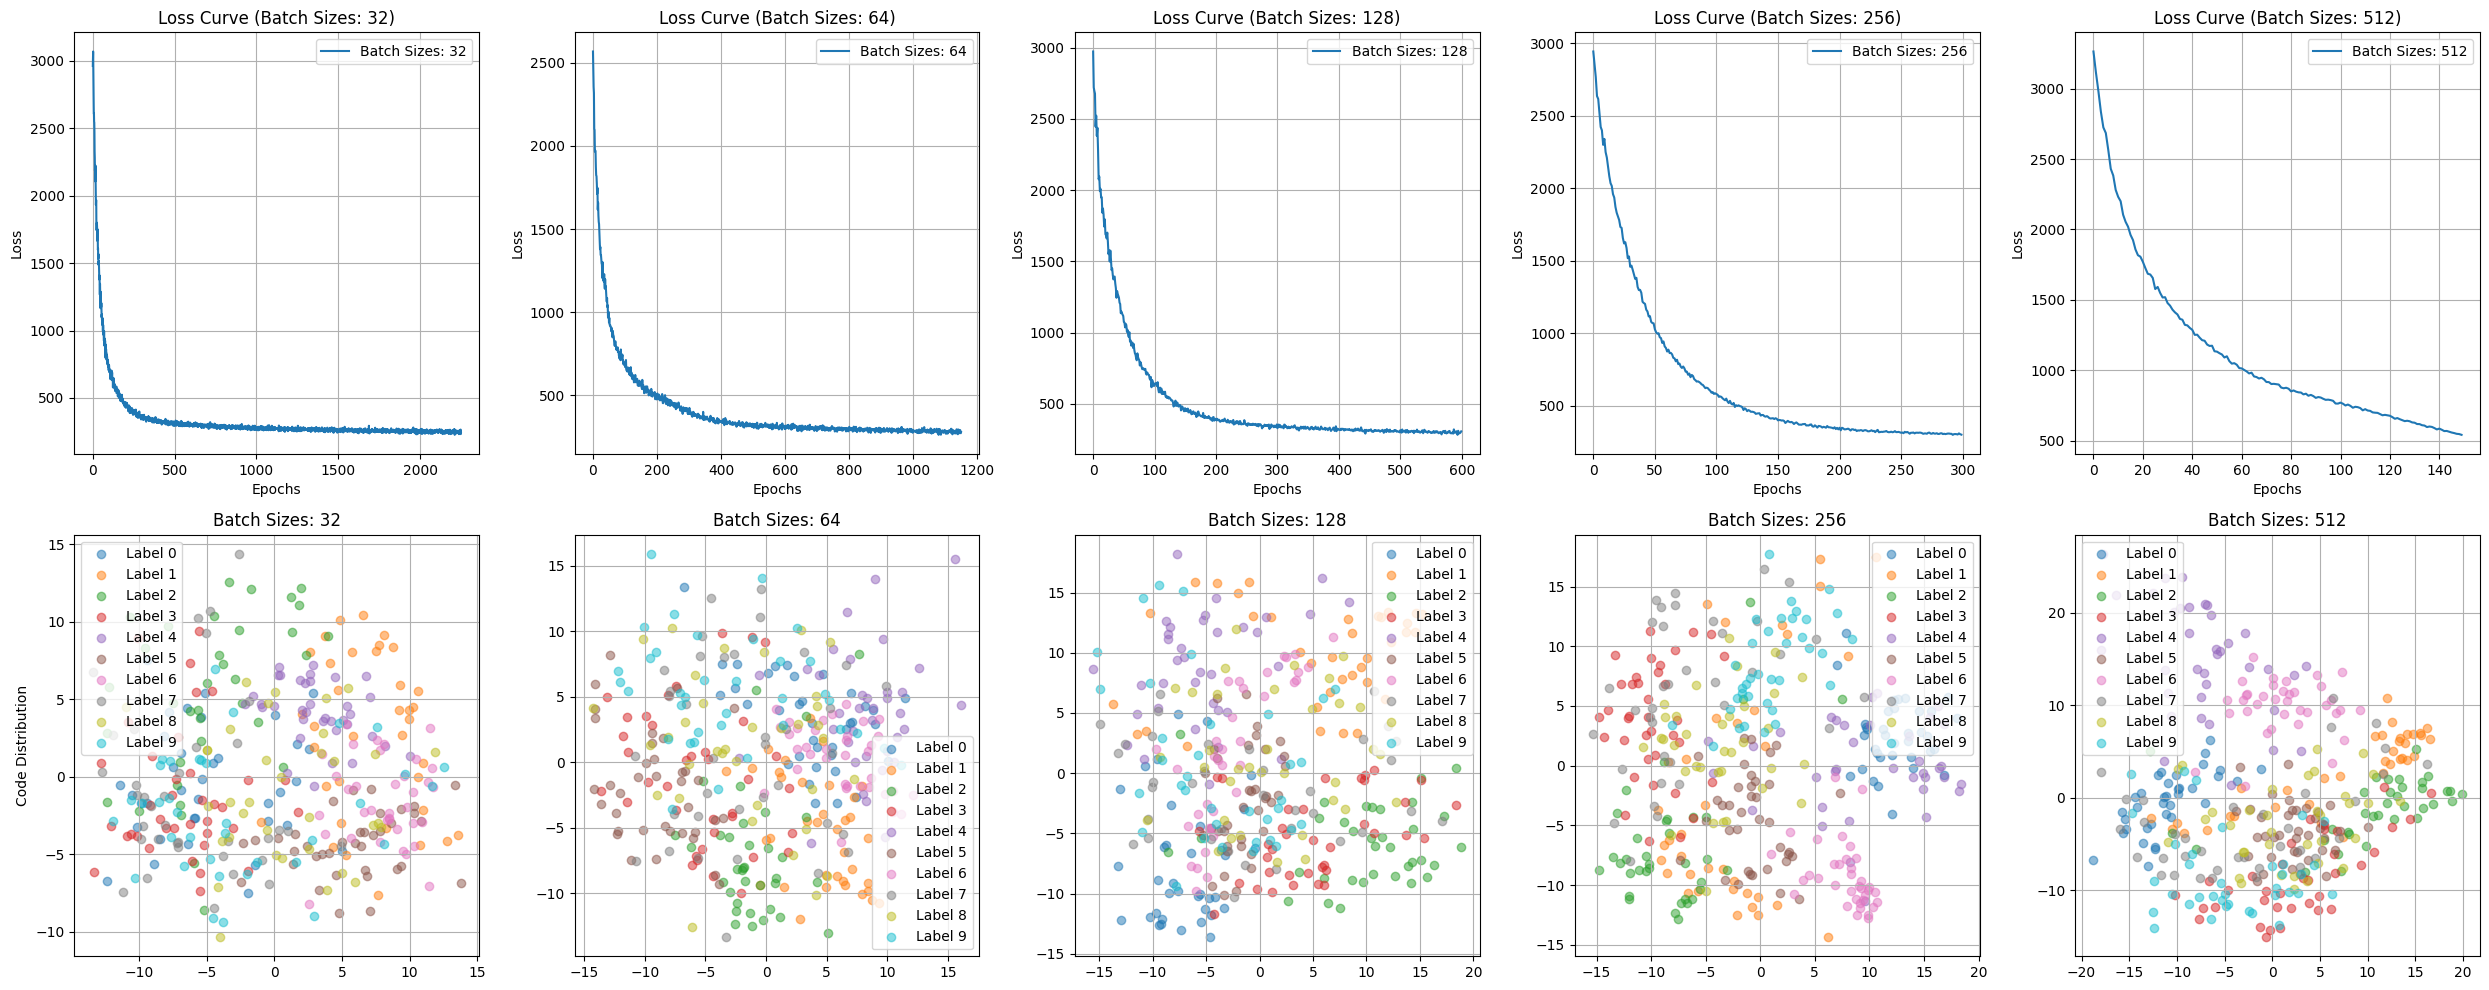

In [41]:
# Plot the results 
plot_hyperparameter_results(
    epochs_results, 
    hyperparameter_values=epochs, 
    hyperparameter_name="Epochs", 
    labels=digits_labels_test
)
plot_hyperparameter_results(
    blocks_result, 
    hyperparameter_values=blocks, 
    hyperparameter_name="Blocks", 
    labels=digits_labels_test
)
plot_hyperparameter_results(
    hidden_size_result, 
    hyperparameter_values=hidden_size, 
    hyperparameter_name="Hidden Layers", 
    labels=digits_labels_test
)
plot_hyperparameter_results(
    batches_results, 
    hyperparameter_values=batch_sizes, 
    hyperparameter_name="Batch Sizes", 
    labels=digits_labels_test
)

In [42]:
# set good hyperparameters
epochs_good = 100
blocks_good = 10
hidden_size_good = 100
batch_size_good = 32

# train a model on the good hyperparameters
model_good = RealNVP(64, hidden_size=hidden_size_good, blocks=blocks_good, device=device)
trainer = train_inn(model_good, digits_data_tensor, epochs=epochs_good, batch_size=batch_size_good)

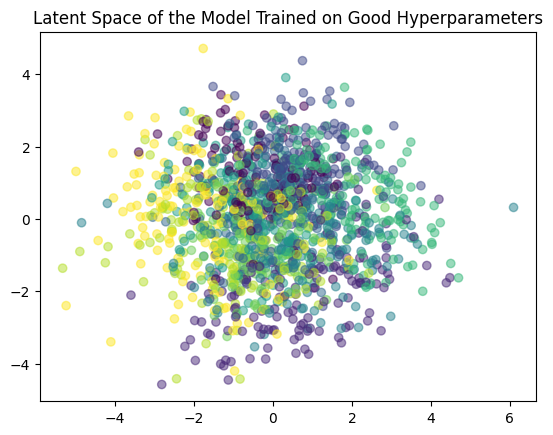

In [45]:
# plot the latent space of the good hyperparameters 
pca = PCA(n_components=2)
distribution_good = model_good.forward(digits_data_tensor, reversed=False)

pca_data_good = pca.fit_transform(distribution_good[0].cpu().detach().numpy())

plt.scatter(pca_data_good[:, 0], pca_data_good[:, 1], c=digits_labels_train, alpha=0.5)
plt.title('Latent Space of the Model Trained on Good Hyperparameters')
plt.show()

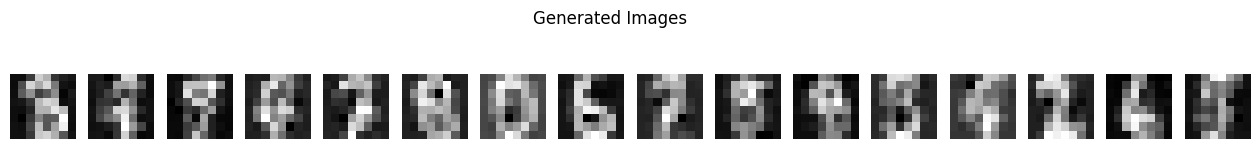

In [46]:
# sample from the model
num_samples = 16
synthetic_data, _ = model_good.sample(num_samples=num_samples, device=device)

synthetic_data= synthetic_data.cpu().detach().numpy()

# plot the synthetic data
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i, ax in enumerate(axes):
    img = synthetic_data[i].reshape((8, 8))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Images")
plt.show()


In [47]:
# update the training function to include the MSE loss 

def train_inn_bottleneck(model, data, epochs=100, lr=0.001, batch_size=64, k=8):
    model = model.to(device)
    
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(model.input_size).to(device),
        torch.eye(model.input_size).to(device)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        for x in data_loader:
            
            x = x.to(device)
            # nll loss
            x_hat, det = model.forward(x)
            log_p = dist.log_prob(x_hat)
            nll_loss = -(log_p + det).mean()

            # mse loss
            #z_k = x_hat.clone()
            reconstruction = model.decoder(x_hat, k)

            mse_loss = nn.MSELoss()(reconstruction, x)

            loss = nll_loss + mse_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'Epoch : {epoch} done')
    return losses

In [48]:
# train model with bottleneck

model_bottleneck = RealNVP(64, hidden_size=hidden_size_good, blocks=blocks_good, device=device)
trainer_bottleneck = train_inn_bottleneck(model_bottleneck, digits_data_tensor, epochs=epochs_good, batch_size=batch_size_good, k=8)

Epoch : 0 done
Epoch : 1 done
Epoch : 2 done
Epoch : 3 done
Epoch : 4 done
Epoch : 5 done
Epoch : 6 done
Epoch : 7 done
Epoch : 8 done
Epoch : 9 done
Epoch : 10 done
Epoch : 11 done
Epoch : 12 done
Epoch : 13 done
Epoch : 14 done
Epoch : 15 done
Epoch : 16 done
Epoch : 17 done
Epoch : 18 done
Epoch : 19 done
Epoch : 20 done
Epoch : 21 done
Epoch : 22 done
Epoch : 23 done
Epoch : 24 done
Epoch : 25 done
Epoch : 26 done
Epoch : 27 done
Epoch : 28 done
Epoch : 29 done
Epoch : 30 done
Epoch : 31 done
Epoch : 32 done
Epoch : 33 done
Epoch : 34 done
Epoch : 35 done
Epoch : 36 done
Epoch : 37 done
Epoch : 38 done
Epoch : 39 done
Epoch : 40 done
Epoch : 41 done
Epoch : 42 done
Epoch : 43 done
Epoch : 44 done
Epoch : 45 done
Epoch : 46 done
Epoch : 47 done
Epoch : 48 done
Epoch : 49 done
Epoch : 50 done
Epoch : 51 done
Epoch : 52 done
Epoch : 53 done
Epoch : 54 done
Epoch : 55 done
Epoch : 56 done
Epoch : 57 done
Epoch : 58 done
Epoch : 59 done
Epoch : 60 done
Epoch : 61 done
Epoch : 62 done
Ep

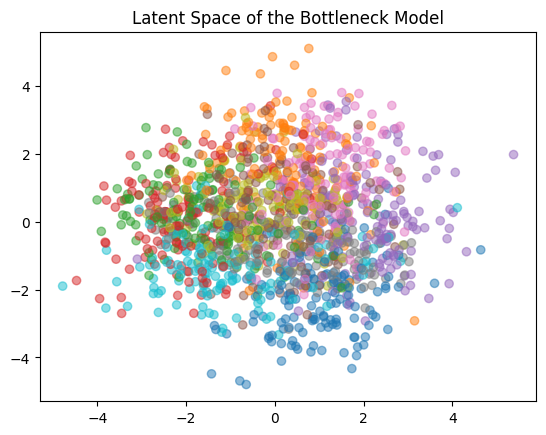

In [50]:
# plot the latent space

forwarded, _ = model_bottleneck.forward(digits_data_tensor)

pca = PCA(n_components=2)

pca_data = pca.fit_transform(forwarded.cpu().detach().numpy())

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=digits_labels_train, cmap='tab10', alpha=0.5)
plt.title("Latent Space of the Bottleneck Model")
plt.show()

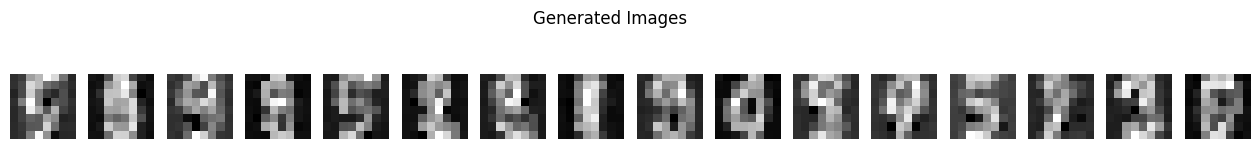

In [51]:
# sample from the model
num_samples = 16
synthetic_data, _ = model_bottleneck.sample(num_samples=num_samples, device=device)

synthetic_data= synthetic_data.cpu().detach().numpy()

# plot the synthetic data
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i, ax in enumerate(axes):
    img = synthetic_data[i].reshape((8, 8))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Images")
plt.show()

Comment: There is no real difference between the two models 

# Exercise 3.3


In [52]:
import torch
from torchvision import datasets , transforms
from torch . utils . data import DataLoader
from PIL import Image , ImageFilter # install ' pillow ' to get PIL
import matplotlib . pyplot as plt
# define a functor to downsample images
class DownsampleTransform:
    def __init__(self , target_shape , algorithm = Image.Resampling.LANCZOS):
        self.width , self.height = target_shape
        self.algorithm = algorithm
    def __call__(self , img ):
        img = img.resize((self.width +2 , self.height +2) , self.algorithm )
        img = img.crop((1 , 1 , self.width +1 , self.height +1))
        return img
# concatenate a few transforms
transform = transforms.Compose([
    DownsampleTransform(target_shape=(8,8)) ,
    transforms.Grayscale(num_output_channels=1) ,
    transforms.ToTensor()
])
# download MNIST
mnist_dataset = datasets.MNIST(root = './data' , train=True, 
        transform=transform, download=True)
# create a DataLoader that serves minibatches of size 100
data_loader = DataLoader(mnist_dataset, batch_size=100 , shuffle=True)
# visualize the first batch of downsampled MNIST images
def show_first_batch(data_loader) :
    for batch in data_loader :
        x , y = batch
        fig = plt.figure(figsize =(10 , 10))
        for i , img in enumerate(x):
            ax = fig.add_subplot(10 , 10 , i+1)
            ax.imshow(img.reshape(8 , 8), cmap = 'gray')
            ax.axis('off')
            break

In [53]:
def train_inn_mnist(model, data_loader, epochs=100, lr=0.001, batch_size=64): 
    model = model.to(device)
    
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(model.input_size).to(device),
        torch.eye(model.input_size).to(device)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)
    #data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        for x in data_loader:
            data, _ = x
            data = data.view(data.size(0), -1).to(device)

            x_hat, det = model.forward(data)
            log_p = dist.log_prob(x_hat)
            loss = -(log_p + det).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'Epoch : {epoch} done')
    return losses

In [54]:
# train model with bottleneck on the mnist dataset
model_mnist = RealNVP(64, hidden_size=100, blocks=10, device=device)
trainer = train_inn_mnist(model_mnist, data_loader, epochs=100)

Epoch : 0 done
Epoch : 1 done
Epoch : 2 done
Epoch : 3 done
Epoch : 4 done
Epoch : 5 done
Epoch : 6 done
Epoch : 7 done
Epoch : 8 done
Epoch : 9 done
Epoch : 10 done
Epoch : 11 done
Epoch : 12 done
Epoch : 13 done
Epoch : 14 done
Epoch : 15 done
Epoch : 16 done
Epoch : 17 done
Epoch : 18 done
Epoch : 19 done
Epoch : 20 done
Epoch : 21 done
Epoch : 22 done
Epoch : 23 done
Epoch : 24 done
Epoch : 25 done
Epoch : 26 done
Epoch : 27 done
Epoch : 28 done
Epoch : 29 done
Epoch : 30 done
Epoch : 31 done
Epoch : 32 done
Epoch : 33 done
Epoch : 34 done
Epoch : 35 done
Epoch : 36 done
Epoch : 37 done
Epoch : 38 done
Epoch : 39 done
Epoch : 40 done
Epoch : 41 done
Epoch : 42 done
Epoch : 43 done
Epoch : 44 done
Epoch : 45 done
Epoch : 46 done
Epoch : 47 done
Epoch : 48 done
Epoch : 49 done
Epoch : 50 done
Epoch : 51 done
Epoch : 52 done
Epoch : 53 done
Epoch : 54 done
Epoch : 55 done
Epoch : 56 done
Epoch : 57 done
Epoch : 58 done
Epoch : 59 done
Epoch : 60 done
Epoch : 61 done
Epoch : 62 done
Ep

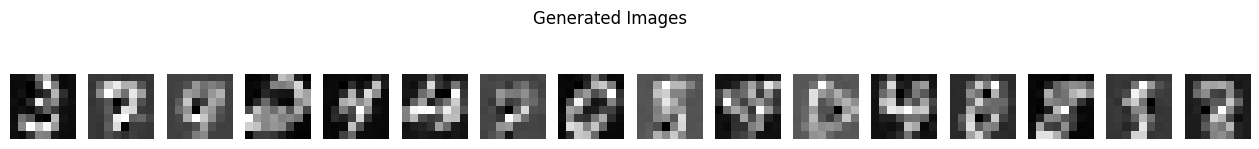

In [55]:
# sample from the trained mnist model 
num_samples = 16
synthetic_data, _ = model_mnist.sample(num_samples=num_samples, device=device)

synthetic_data= synthetic_data.cpu().detach().numpy()

# plot the synthetic data
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i, ax in enumerate(axes):
    img = synthetic_data[i].reshape(8, 8)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle("Generated Images")
plt.show()

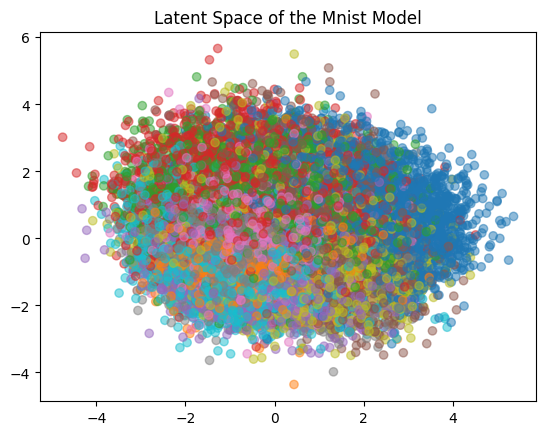

In [56]:
# plot the code space for mnist
mnist_labels = mnist_dataset.targets.numpy()
latent_space = []

for image, _ in mnist_dataset:
    image = image.view(1, -1).to(device)
    latent, _ = model_mnist.forward(image)

    latent_space.append(latent.cpu().detach().numpy())

latent_space = np.concatenate(latent_space, axis=0)

pca = PCA(n_components=2)

pca_data = pca.fit_transform(latent_space)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=mnist_labels, cmap='tab10', alpha=0.5)
plt.title("Latent Space of the Mnist Model")
plt.show()

# Exercise 4

In [57]:
# use a random forrest classifier to classify the samples from the model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [58]:
# train a conditioned model on good hyperparameters
model_digits_cond = RealNVPCond(input_size=64, condition_size=10, hidden_size=100, blocks=10, device=device)
trainer_cond = train_inn_cond(model_digits_cond, digits_data_tensor, digits_labels_tensor, epochs=100, batch_size=32)

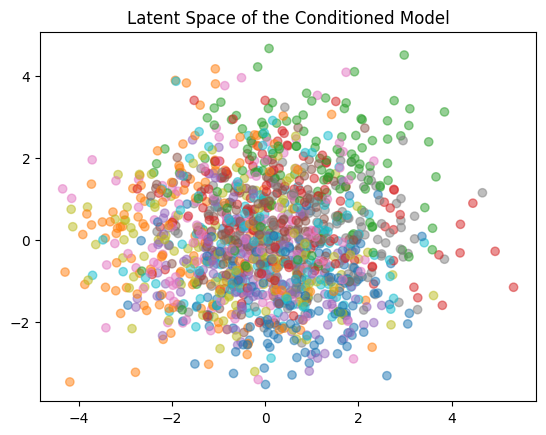

In [59]:
# plot the latent space of the conditioned model
digits_onehot_labels = torch.nn.functional.one_hot(digits_labels_tensor.long(), num_classes=10).float()

forwarded, _ = model_digits_cond.forward(digits_data_tensor, conditions=digits_onehot_labels, reversed=False)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(forwarded.cpu().detach().numpy())

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=digits_labels_train, cmap='tab10', alpha=0.5)
plt.title('Latent Space of the Conditioned Model')
plt.show()


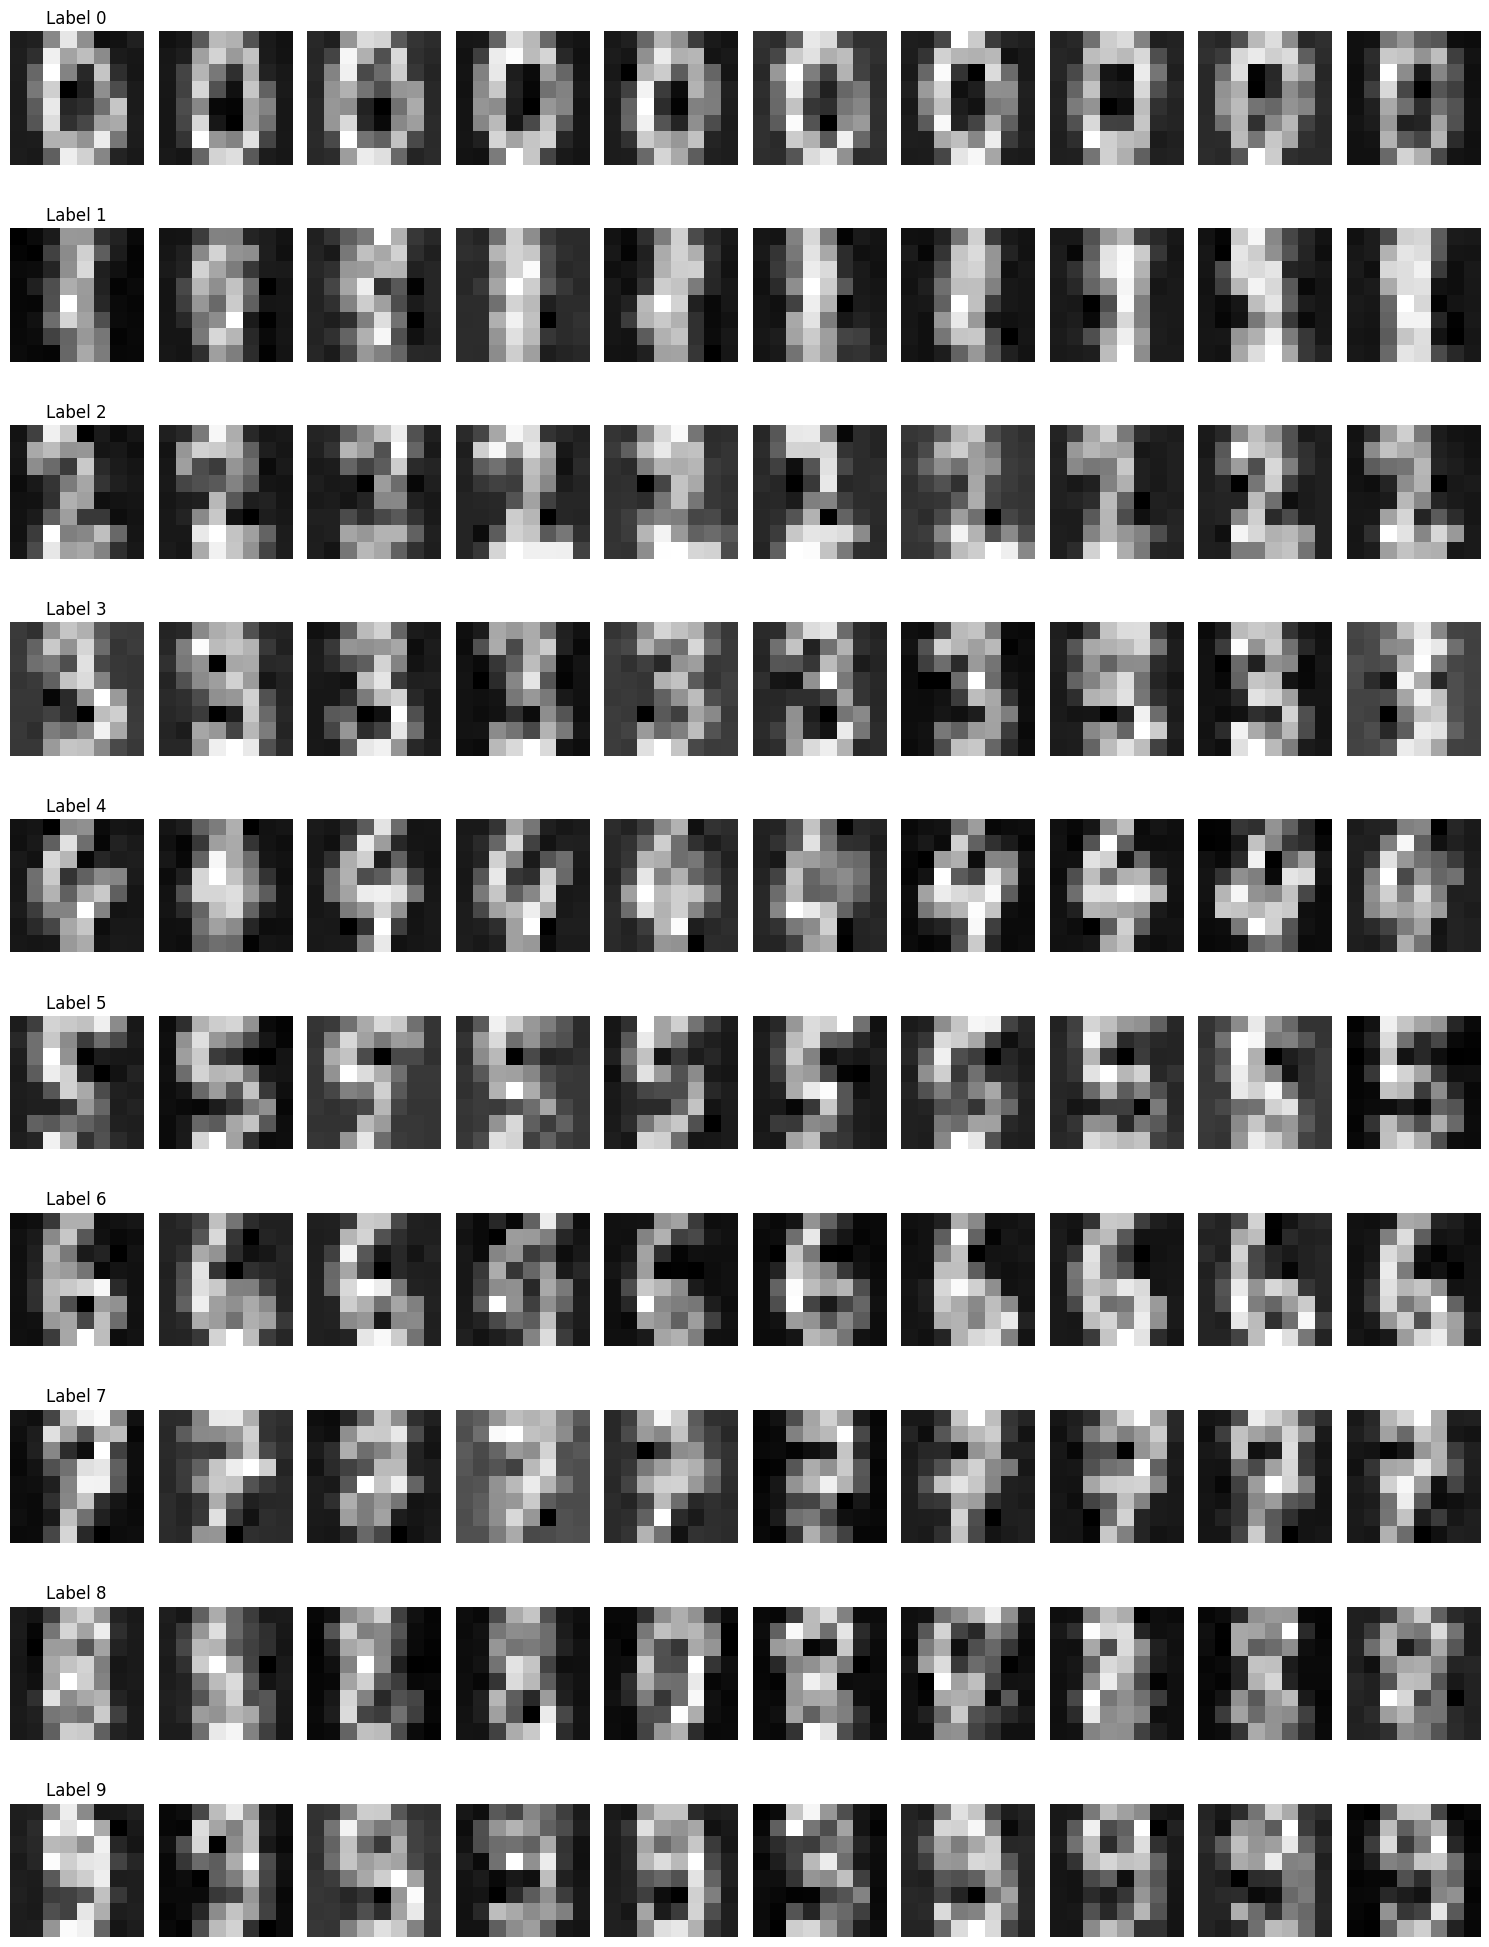

In [60]:
# Number of samples per condition
num_samples = 10
# Define the conditions for sampling (one-hot encoded for 10 classes)
# One-hot encoded tensor for 10 classes
conditions = torch.eye(10).to(device)  # Creates a 10x10 identity matrix, each row is a one-hot vector

# Sample from the model conditioned on the 10 labels
samples = model_digits_cond.sample(num_samples=num_samples, conditions=conditions)

# Plot the samples for each condition (label)
fig, axes = plt.subplots(10, num_samples, figsize=(15, 20))
for i in range(10):  # Iterate over the 10 conditions (10 classes)
    for j in range(num_samples):
        ax = axes[i, j]
        ax.imshow(samples[i, j].cpu().detach().numpy().reshape(8, 8), cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Label {i}")
plt.tight_layout()
plt.show()

In [61]:
# train a random forrest classifier to test the quality of the generated data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(digits_data_train, digits_labels_train)


# Generate synthetic data
num_samples = 1000
synthetic_data = model_digits_cond.sample(num_samples, conditions)
synthetic_data = synthetic_data.cpu().detach().numpy()

# create a vector of the real labels for the synthetic data 
synthetic_labels = np.repeat(np.arange(10), num_samples)

# reshape the synthetic data to fit the classifier
synthetic_data = synthetic_data.reshape(-1, 64)

# Predict the labels of the synthetic data
synthetic_labels = rf_classifier.predict(synthetic_data)


# Compute the accuracy of the classifier on the synthetic data
accuracy = accuracy_score(synthetic_labels, synthetic_labels)
print(f"Accuracy of the Random Forrest Classifier on the synthetic data: {accuracy:.4f}")

Accuracy of the Random Forrest Classifier on the synthetic data: 1.0000


In [62]:
# update the trainer to include condition and bottleneck
def train_inn_bottleneck_cond(model, data, labels, epochs=100, lr=0.001, batch_size=64, k=8):
    model = model.to(device)
    
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(model.input_size).to(device),
        torch.eye(model.input_size).to(device)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)
    data_loader = torch.utils.data.DataLoader(list(zip(data, labels)), batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        for x in data_loader:
            data_batch = x[0].to(device)
            label_batch = x[1].to(device)

            one_hot_labels = nn.functional.one_hot(label_batch.long(), num_classes=model.condition_size).float()
            # nll loss
            x_hat, det = model.forward(data_batch, one_hot_labels)
            log_p = dist.log_prob(x_hat)
            nll_loss = -(log_p + det).mean()

            # mse loss
            #z_k = x_hat.clone()
            reconstruction = model.decoder(x_hat, one_hot_labels, k)
            mse_loss = nn.MSELoss()(reconstruction, data_batch)

            loss = nll_loss + mse_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'Epoch : {epoch} done')
    return losses

In [63]:
# train a model with bottleneck and condition on the digits dataset 
model_bottleneck_cond = RealNVPCond(64, 10, hidden_size=100, blocks=10, device=device)
trainer_bottleneck_cond = train_inn_bottleneck_cond(model_bottleneck_cond, digits_data_tensor, digits_labels_tensor, epochs=epochs_good, batch_size=batch_size_good, k=8)


Epoch : 0 done
Epoch : 1 done
Epoch : 2 done
Epoch : 3 done
Epoch : 4 done
Epoch : 5 done
Epoch : 6 done
Epoch : 7 done
Epoch : 8 done
Epoch : 9 done
Epoch : 10 done
Epoch : 11 done
Epoch : 12 done
Epoch : 13 done
Epoch : 14 done
Epoch : 15 done
Epoch : 16 done
Epoch : 17 done
Epoch : 18 done
Epoch : 19 done
Epoch : 20 done
Epoch : 21 done
Epoch : 22 done
Epoch : 23 done
Epoch : 24 done
Epoch : 25 done
Epoch : 26 done
Epoch : 27 done
Epoch : 28 done
Epoch : 29 done
Epoch : 30 done
Epoch : 31 done
Epoch : 32 done
Epoch : 33 done
Epoch : 34 done
Epoch : 35 done
Epoch : 36 done
Epoch : 37 done
Epoch : 38 done
Epoch : 39 done
Epoch : 40 done
Epoch : 41 done
Epoch : 42 done
Epoch : 43 done
Epoch : 44 done
Epoch : 45 done
Epoch : 46 done
Epoch : 47 done
Epoch : 48 done
Epoch : 49 done
Epoch : 50 done
Epoch : 51 done
Epoch : 52 done
Epoch : 53 done
Epoch : 54 done
Epoch : 55 done
Epoch : 56 done
Epoch : 57 done
Epoch : 58 done
Epoch : 59 done
Epoch : 60 done
Epoch : 61 done
Epoch : 62 done
Ep

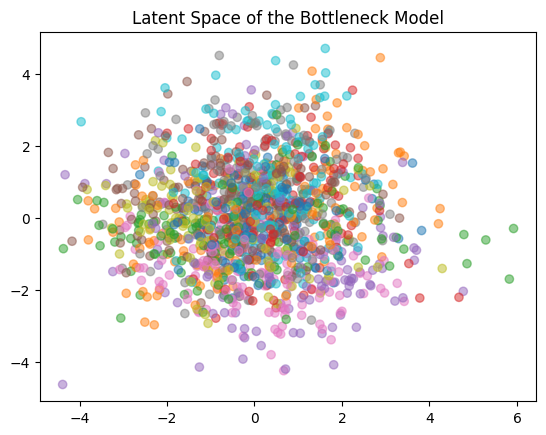

In [65]:
# plot the code space for the load digits dataset
digits_labels_one_hot = nn.functional.one_hot(digits_labels_tensor.long(), num_classes=10).float()
forwarded, _ = model_bottleneck_cond.forward(digits_data_tensor, digits_labels_one_hot)

pca = PCA(n_components=2)

pca_data = pca.fit_transform(forwarded.cpu().detach().numpy())

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=digits_labels_train, cmap='tab10', alpha=0.5)
plt.title("Latent Space of the Bottleneck Model")
plt.show()


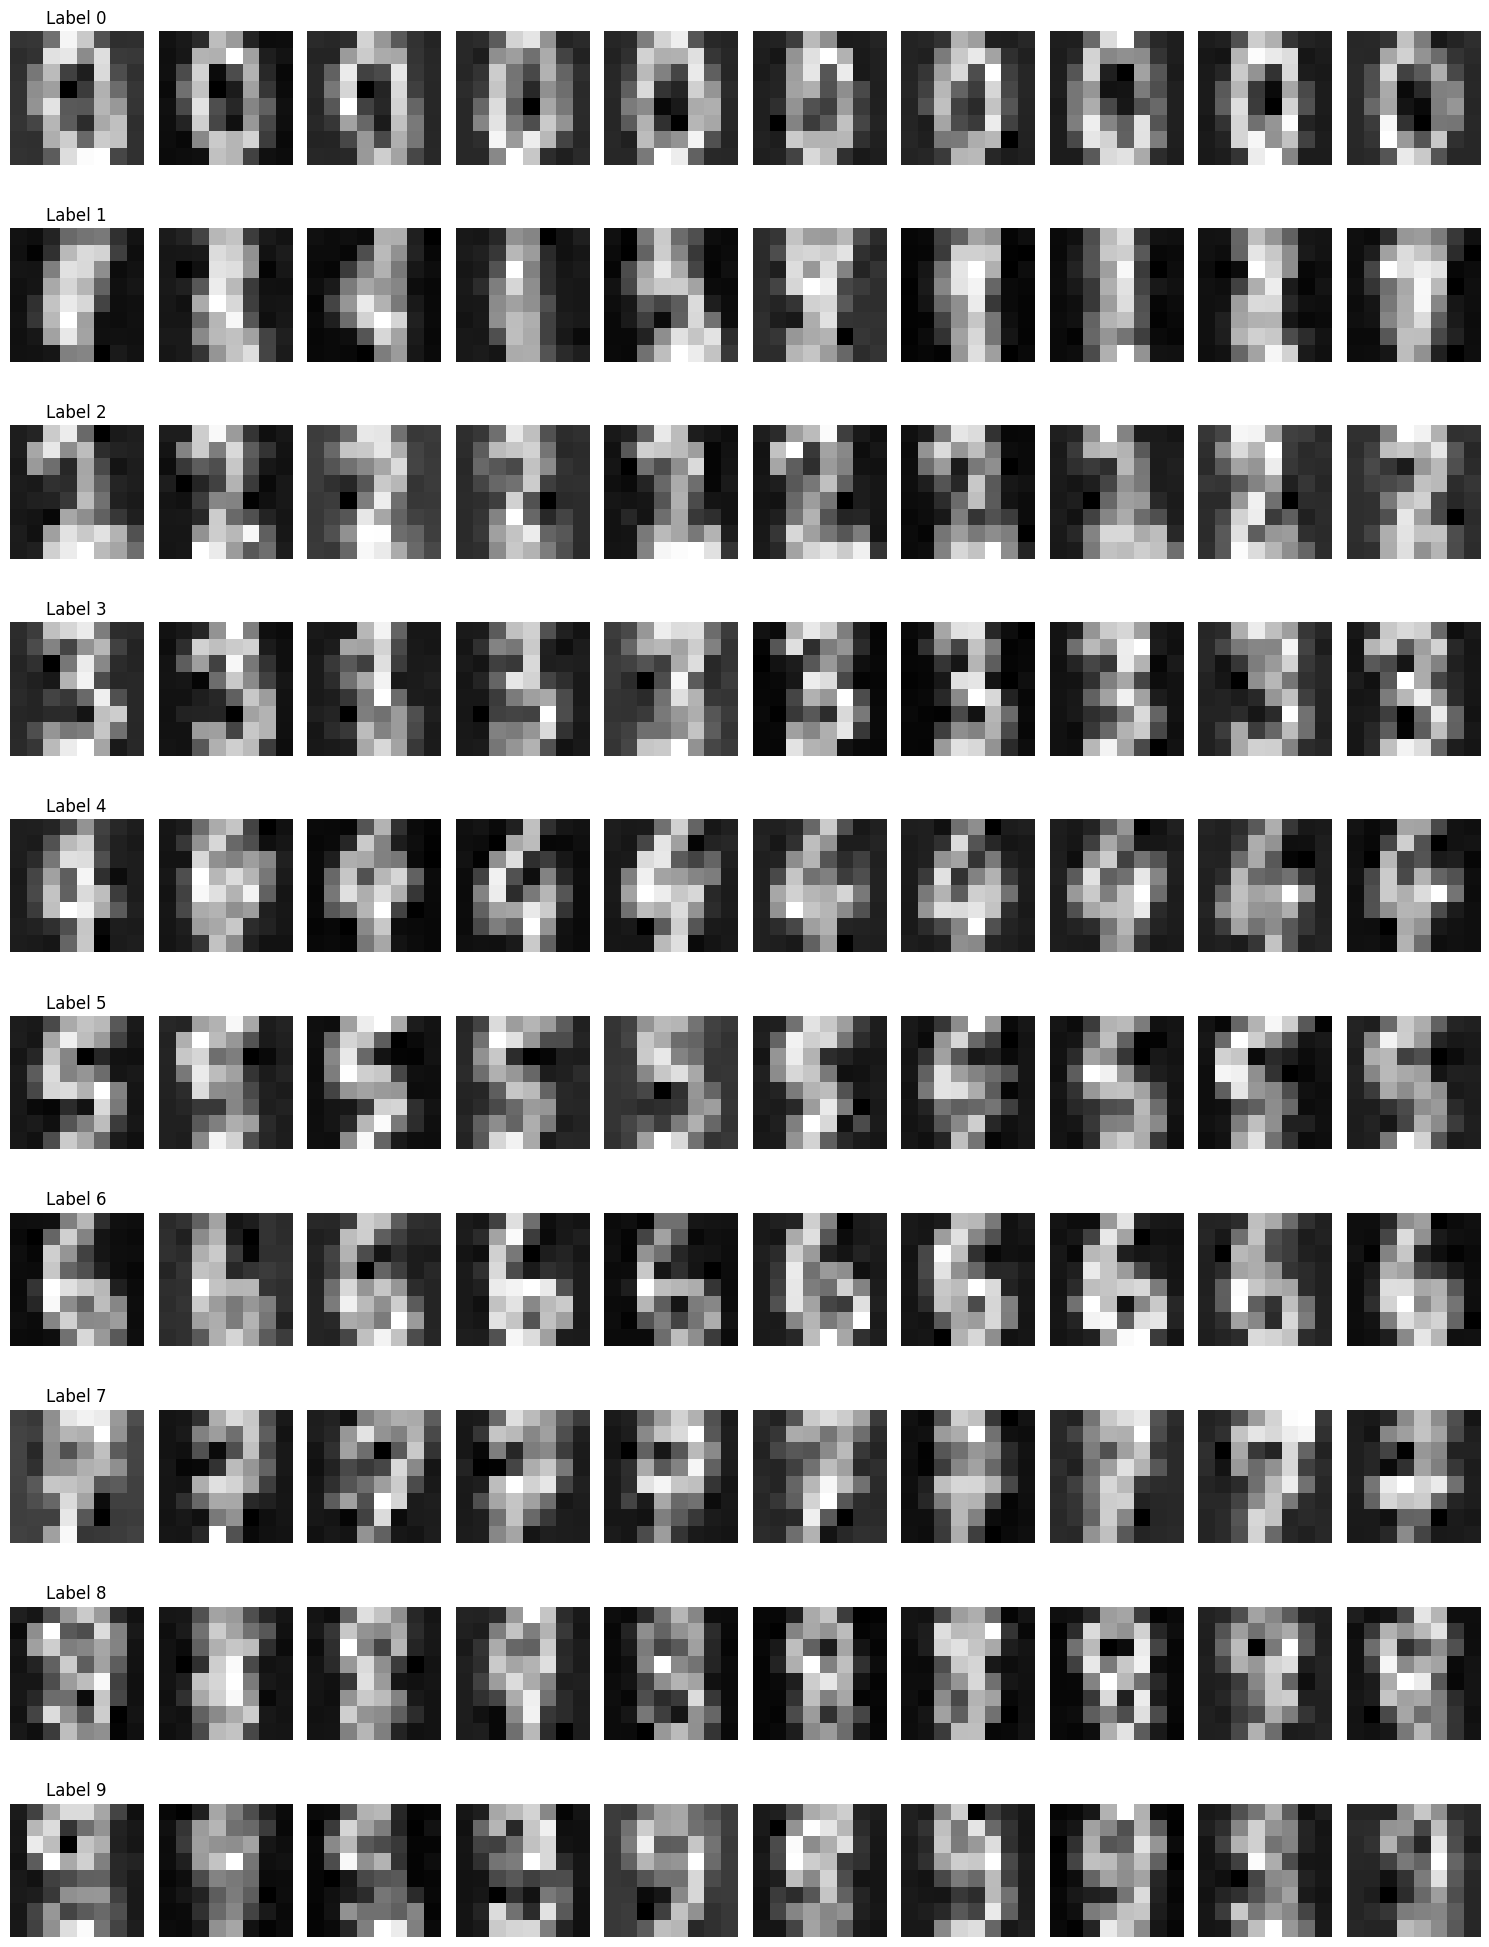

In [66]:
# Number of samples per condition
num_samples = 10

# Define the conditions for sampling (one-hot encoded for 10 classes)
# One-hot encoded tensor for 10 classes
conditions = torch.eye(10).to(device)  # Creates a 10x10 identity matrix, each row is a one-hot vector

# Sample from the model conditioned on the 10 labels
samples = model_bottleneck_cond.sample(num_samples=num_samples, conditions=conditions)

# Plot the samples for each condition (label)
fig, axes = plt.subplots(10, num_samples, figsize=(15, 20))
for i in range(10):  # Iterate over the 10 conditions (10 classes)
    for j in range(num_samples):
        ax = axes[i, j]
        ax.imshow(samples[i, j].cpu().detach().numpy().reshape(8, 8), cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Label {i}")
plt.tight_layout()
plt.show()

In [67]:
# Generate synthetic data
num_samples = 1000
synthetic_data = model_bottleneck_cond.sample(num_samples, conditions)
synthetic_data = synthetic_data.cpu().detach().numpy()

# create a vector of the real labels for the synthetic data 
synthetic_labels = np.repeat(np.arange(10), num_samples)

# reshape the synthetic data to fit the classifier
synthetic_data = synthetic_data.reshape(-1, 64)

# Predict the labels of the synthetic data
synthetic_labels = rf_classifier.predict(synthetic_data)


# Compute the accuracy of the classifier on the synthetic data
accuracy = accuracy_score(synthetic_labels, synthetic_labels)
print(f"Accuracy of the Random Forrest Classifier on the synthetic data: {accuracy:.4f}")

Accuracy of the Random Forrest Classifier on the synthetic data: 1.0000


The synthetic data is already really good. I did not retrain with the mnist dataset, cause it requires a long time to run and the results are already really good